In [1]:
# w = 15 로 돌려보자
# lr = 0.0001
# lambda_1 = 0.01
# h = 128
# loss 0.7밑으로 안내려갑니다...

In [2]:
# 모듈 import
from datetime import datetime
import numpy as np
import os
import pandas as pd

#from google.colab import drive
#drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/MyDrive/python/python_dong/data_axis_transform1')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

#!pip install torchmetrics
import torchmetrics

#!pip install torchinfo
from torchinfo import summary

import matplotlib.pyplot as plt
import math


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# 1. 데이터 전처리

In [3]:
# data path 지정
raw_data_path = './data/stocknet-dataset/price/raw'

if 'stocknet' in raw_data_path:
    tra_date = '2014-01-02'
    val_date = '2015-08-03'
    tes_date = '2015-10-01'
    end_date = '2015-12-31'
elif 'kdd17' in raw_data_path:
    tra_date = '2007-01-03'
    val_date = '2015-01-02'
    tes_date = '2016-01-04'
    end_date = '2016-12-31'
else:
    print('unexpected path: %s' % raw_data_path)

# os.path.isfile : 파일이 있는지 없는 지 체크
# os.path.join(data_path, fname) : 폴더 디렉터리와 fname(stockname.csv) 붙임
fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

COLUMNS_FEATURE_DATA_V1 = ['open_close_ratio', 'high_close_ratio', 
                           'low_close_ratio', 'close_lastclose_ratio', 
                           'adjclose_lastadjclose_ratio', 'close_ma5_ratio', 
                           'close_ma10_ratio', 'close_ma15_ratio', 'close_ma20_ratio', 
                           'close_ma25_ratio', 'close_ma30_ratio']

ver = 'v1' # ver in ['v1', 'v2']
if ver == 'v1':
    COLUMNS_FEATURE = COLUMNS_FEATURE_DATA_V1

In [4]:
windows = [5,10,15,20,25,30]

def preprocess(df, windows):
   '''
   전처리 함수 역할 : 전체 feature생성하여 df column에 추가
   '''
   data = df
   data['open_close_ratio'] = data['Open'] / data['Close'] - 1
   data['high_close_ratio'] = data['High'] / data['Close'] - 1
   data['low_close_ratio'] = data['Low'] / data['Close'] - 1

   data['close_lastclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'close_lastclose_ratio'] = data['Close'][1:].values / data['Close'][:-1].values - 1

   data['adjclose_lastadjclose_ratio'] = np.zeros(len(data))
   data.loc[1:, 'adjclose_lastadjclose_ratio'] = data['Adj Close'][1:].values / data['Adj Close'][:-1].values - 1

   for window in windows:
      data[f'close_ma{window}_ratio'] = data['Adj Close'].rolling(window).mean()/data['Adj Close'] - 1
   
   data['label'] = np.append((data['Close'][1:].values > data['Close'][:-1].values)*1,0)

   return data

In [5]:
feature_data_path = './data/stocknet-dataset/price/feature'

for fname in fnames:
   if not os.path.isfile(os.path.join(feature_data_path,fname)):
      df_raw = pd.read_csv(os.path.join(raw_data_path,fname))
      data = preprocess(df_raw, windows)

      # 폴더 없으면 생성
      try:
         if not os.path.exists(feature_data_path):
            os.makedirs(feature_data_path)
      except OSError:
         print ('Error: Creating directory. ' +  feature_data_path)

      #csv 파일 저장
      data.to_csv(os.path.join(feature_data_path,fname))



# train, validation, test data 나누기

## 1. input data 3차원으로 쌓기
shape = (stock 종류수, date, feature)



요건
1. 모든 티커 데이터의 date가 맞는지?
2. 결측치는 없는지?
3. 티커와 데이터 메치 가능해야함

In [6]:
raw_data_path = './data/stocknet-dataset/price/raw'


tra_data_X = []
tra_data_Y = []
val_data_X = []
val_data_Y = []
test_data_X = []
test_data_Y = []
tickers = []

cnt = 0
fail_cnt = 0

fnames = [fname for fname in os.listdir(raw_data_path) if
            os.path.isfile(os.path.join(raw_data_path,fname))]

for fname in fnames:

    df = pd.read_csv(os.path.join(raw_data_path,fname))
    data = preprocess(df, windows)

    learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
    tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
    tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

    val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
    val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

    test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
    test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']


    if cnt == 0:
        target_dates = learning_data
    
    print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
    if np.array_equal(target_dates.values, learning_data.values): 
        
        tra_data_X.append(tra_data_X_ticker.values)
        tra_data_Y.append(tra_data_Y_ticker.values)

        val_data_X.append(val_data_X_ticker.values)
        val_data_Y.append(val_data_Y_ticker.values)
        
        test_data_X.append(test_data_X_ticker.values)
        test_data_Y.append(test_data_Y_ticker.values)

        tickers.append(fname)
    else : 
        fail_cnt += 1
    
    cnt += 1

print(cnt, len(fnames))
print('fail_cnt :', fail_cnt)

# 마지막에 index 종목 넣기
raw_data_index_path = './data/stocknet-dataset/price/raw/index'

fname = os.listdir(raw_data_index_path)[0]

df = pd.read_csv(os.path.join(raw_data_index_path,fname))
data = preprocess(df, windows)

learning_data = data[(data['Date'] >= tra_date) & (data['Date'] <= end_date)]['Date']
tra_data_X_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)][COLUMNS_FEATURE]
tra_data_Y_ticker = data[(data['Date'] >= tra_date) & (data['Date'] < val_date)]['label']

val_data_X_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)][COLUMNS_FEATURE]
val_data_Y_ticker = data[(data['Date'] >= val_date) & (data['Date'] < tes_date)]['label']

test_data_X_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)][COLUMNS_FEATURE]
test_data_Y_ticker = data[(data['Date'] >= tes_date) & (data['Date'] <= end_date)]['label']

print('ticker : {}, date check : {}'.format(fname, np.array_equal(target_dates.values, learning_data.values)))
if np.array_equal(target_dates.values, learning_data.values):
    
    tra_data_X.append(tra_data_X_ticker.values)
    # tra_data_Y.append(tra_data_Y_ticker.values)

    val_data_X.append(val_data_X_ticker.values)
    # val_data_Y.append(val_data_Y_ticker.values)
    
    test_data_X.append(test_data_X_ticker.values)
    # test_data_Y.append(test_data_Y_ticker.values)

    tickers.append(fname)

# tra_data_X

ticker : AAPL.csv, date check : True
ticker : ABB.csv, date check : True
ticker : ABBV.csv, date check : True
ticker : AEP.csv, date check : True
ticker : AGFS.csv, date check : False
ticker : AMGN.csv, date check : True
ticker : AMZN.csv, date check : True
ticker : BA.csv, date check : True
ticker : BABA.csv, date check : False
ticker : BAC.csv, date check : True
ticker : BBL.csv, date check : True
ticker : BCH.csv, date check : True
ticker : BHP.csv, date check : True
ticker : BP.csv, date check : True
ticker : BRK-A.csv, date check : True
ticker : BSAC.csv, date check : True
ticker : BUD.csv, date check : True
ticker : C.csv, date check : True
ticker : CAT.csv, date check : True
ticker : CELG.csv, date check : True
ticker : CHL.csv, date check : True
ticker : CHTR.csv, date check : True
ticker : CMCSA.csv, date check : True
ticker : CODI.csv, date check : True
ticker : CSCO.csv, date check : True
ticker : CVX.csv, date check : True
ticker : D.csv, date check : True
ticker : DHR.csv,

In [7]:
def list_to_tensor(list_):
    return torch.Tensor(np.array(list_))

In [8]:
tensor_tra_data_X = list_to_tensor(tra_data_X)
tensor_tra_data_Y = list_to_tensor(tra_data_Y).view((len(tra_data_Y),-1,1))
tensor_val_data_X = list_to_tensor(val_data_X)
tensor_val_data_Y = list_to_tensor(val_data_Y).view((len(val_data_Y),-1,1))
tensor_test_data_X = list_to_tensor(test_data_X)
tensor_test_data_Y = list_to_tensor(test_data_Y).view((len(test_data_Y),-1,1))

## Hyperparameter setting

In [38]:
w = 15 # window size w in {10, 15}
beta = 0.1 # market context weight beta in {0.01, 0.1, 1}
h = 128 # hidden layer size h in {64, 128}
learning_rate = 0.0001 # in {0.001, 0.0001}
lambda_1 = 1 # selective regularzation lambda = 1
drop_rate = 0.15
feature_size = len(COLUMNS_FEATURE)

In [39]:
class Feature_transformation_layer(nn.Module):
    """Feature transformation layer in DTML"""

    def __init__(self, feature_size, h):
        super(Feature_transformation_layer, self).__init__()
        self.feature_size = feature_size
        self.h = h

        self.linear = nn.Linear(self.feature_size, self.h)
    
    def forward(self, X):
        output = torch.tanh(self.linear(X))
        return output

In [40]:
def layer_normalization(tensor):
    h = tensor.size()[-1]
    return (tensor - torch.std_mean(tensor, dim=1, unbiased=False)[1].repeat((h,1)).transpose(-2,-1))/torch.std_mean(tensor, dim=1, unbiased=False)[0].repeat((h,1)).transpose(-2,-1)

In [41]:
class Nonlinear_transformation(nn.Module):
    """Nonlinear transformation in DTML"""

    def __init__(self, h):
        super(Nonlinear_transformation, self).__init__()
        self.h = h


        self.mlp1 = nn.Linear(self.h, self.h * 4)
        self.mlp2 = nn.Linear(self.h * 4, h)
    
    def forward(self, H, H_tilda, on_train=True):
        H_p = H + H_tilda
        H_p = self.mlp1(H_p)
        H_p = nn.ReLU()(H_p)
        H_p = self.mlp2(H_p)
        H_p = H + H_tilda + H_p
        H_p = nn.Tanh()(H_p)

        # dropout and layer normalization
        if on_train == True:
            H_p = nn.Dropout(p=drop_rate)(H_p)
        H_p = layer_normalization(H_p)
        return H_p

In [42]:
class Final_prediction(nn.Module):
    """final prediction in DTML"""

    def __init__(self, h):
        super(Final_prediction, self).__init__()
        self.h = h

        self.pred_linear = nn.Linear(h,1)
    
    def forward(self, H_p):
        y_hat = self.pred_linear(H_p)
        y_hat = nn.Sigmoid()(y_hat).view((-1))

        return y_hat

In [48]:
class DTML(nn.Module):
    ''' DTML '''

    def __init__(self, X, y, w, h, beta, vali_X, vali_y, test_X, test_y,
                 batch_size,
                 learning_rate, epochs):
        """ Initialize """
        super(DTML, self).__init__()
        self.X = X
        self.y = y
        self.vali_X = vali_X
        self.vali_y = vali_y
        self.test_X = test_X
        self.test_y = test_y
        self.w = w
        self.h = h
        self.beta = beta
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.train_timesteps = train_timesteps = int(X.size()[1]) - w

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator : ", self.device)

        self.Feature_transformation_layer = Feature_transformation_layer(feature_size=self.X.size()[-1],
                                                                         h=self.h)
        
        # 티커별로 lstm 층 개별로 만들기
        for i in range(self.X.size()[0]): # 마지막은 index용 lstm
            self._modules['lstm_{}'.format(i)] = nn.LSTM(input_size = self.h, hidden_size=self.h, batch_first=True)
        
        # ticker별로 linear layer 생성
        for i in range(self.X.size()[0]):
            self._modules['ContextNormalLinearLayer_{}'.format(i)] = nn.Linear(h, h)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=self.h, num_heads=8, dropout=drop_rate)
        self.query_layer = nn.Linear(self.h, self.h)
        self.key_layer = nn.Linear(self.h, self.h)
        self.value_layer = nn.Linear(self.h, self.h)

        self.Nonlinear_transformation = Nonlinear_transformation(h=self.h)

        self.Final_prediction = Final_prediction(h=self.h)
        print(len(list(self.parameters())))

        # Loss funciton
        self.criterion = nn.BCELoss()

        self.optimizer = optim.Adam(params=filter(lambda p:p.requires_grad, self.parameters()), lr=self.learning_rate)

    def window_(self, tensor, time_idx, window_size):
        # tensor size = (ticker_number, dates, feature_size)    
        return tensor[:, time_idx:time_idx + self.w, :]


    def train(self):
        mode = 'train'
        if mode == 'train':
            X = self.X
            y_data = self.y
            epochs = self.epochs
        elif mode == 'validation':
            X = self.vali_X
            y_data = self.vali_y
            epochs = 1
        
        elif mode == 'test':
            X = self.test_X
            y_data = self.test_y
            epochs = 1

        else:
            print('유효하지 않는 mode입니다.')
            

        timesteps = int(X.size()[1]) - w

        """training process"""
        # epoch당 iteration 수
        iter_per_epoch = int(np.ceil(timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.iter_losses = np.zeros(epochs * iter_per_epoch)
        self.iter_acc = np.zeros(epochs * iter_per_epoch)
        self.iter_mcc = np.zeros(epochs * iter_per_epoch)
        self.iter_precision = np.zeros(epochs * iter_per_epoch)
        self.return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.index_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.com_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.index_com_return_rate = np.zeros((epochs, timesteps))

        # epoch당 loss
        self.epoch_losses = np.zeros(epochs)
        self.epoch_acc = np.zeros(epochs)
        self.epoch_mcc = np.zeros(epochs)
        self.epoch_precision = np.zeros(epochs)

        # epoch당 loss (Validation)
        self.vali_epoch_losses = np.zeros(epochs)
        self.vali_epoch_acc = np.zeros(epochs)
        self.vali_epoch_mcc = np.zeros(epochs)
        self.vali_epoch_precision = np.zeros(epochs)

        vali_timesteps = int(self.vali_X.size()[1]) - w

        """training process"""
        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.vali_iter_losses = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_acc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_mcc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_precision = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_com_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_com_return_rate = np.zeros((epochs, vali_timesteps))

        train_n_iter = 0

        for epoch in range(self.epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(X)

            while (time_idx < timesteps):
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tra_data_Y_w = self.window_(y_data, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((X.size()[0], self.h))
                for i in range(self.X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(X.size()[0], self.h)
                for i in range(X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외


                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]
                #Q = self.query_layer(H)
                #K = self.key_layer(H)
                #V = self.value_layer(H)

                # S 생성
                #S = torch.matmul(Q, K.transpose(-2,-1))
                #S = S/math.sqrt(h)
                #S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                #H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation --> attention후, drop-out 하라고 논문에 있음
                #H_tilda = nn.Dropout(p=drop_rate)(H_tilda) -> multihead에 dropout 포함되어있습니다.
                H_tilda = layer_normalization(H_tilda)

                if mode == 'train':
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=True)
                else:
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False)

                y_hat = self.Final_prediction(H_p)
                y = tra_data_Y_w[:,w-1,:].view((-1))

                if mode == 'train':
                    self.optimizer.zero_grad()

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                
                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                # print(y_hat.topk(3)[1], X[y_hat.topk(3)[1],time_idx + w - 1,4], X[y_hat.topk(3)[1],time_idx + w,4])
                index_return_rate = X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                if mode == 'train':
                    loss_reg.backward(retain_graph=True)
                    self.optimizer.step()
              

                self.iter_losses[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.iter_acc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = acc
                self.iter_mcc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.iter_precision[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = precision
                self.return_rate[epoch, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.index_return_rate[epoch, time_idx] = index_return_rate
                self.com_return_rate[epoch, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.index_com_return_rate[epoch, time_idx] = index_com_return_rate # batch_size 적용하면 수정해야함    

                '''
                if time_idx % 1000 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision,
                          "return_rate", return_rate,
                          "com_return_rate", com_return_rate)
                '''
                

                time_idx += self.batch_size
                train_n_iter += 1                

                if train_n_iter % 100 == 0 and train_n_iter != 0:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                
                ######### 공통부분 끝, 데이터 수집 시작

            self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_acc[epoch] = np.mean(self.iter_acc[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_mcc[epoch] = np.mean(self.iter_mcc[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            
            self.epoch_precision[epoch] = np.mean(self.iter_precision[range(
                epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(timesteps), self.com_return_rate[epoch][:timesteps], label='portfolio')
            plt.plot(range(timesteps), self.index_com_return_rate[0][ : timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.iter_losses[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.iter_acc[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()

            if epoch % 1 == 0:
                plt.subplot(2,1,1)
                plt.plot(range(epoch + 1), self.epoch_losses[:epoch + 1], label=mode)
                plt.legend(loc='upper left')
                plt.ylabel('loss_reg')

                plt.subplot(2,1,2)
                plt.plot(range(epoch + 1), self.epoch_acc[:epoch + 1], label=mode)
                plt.legend(loc='upper left')
                plt.ylabel('acc')

                plt.show()

            if epoch % 1 == 0:
                print("Epochs : ", epoch, "Iterations : ", train_n_iter,
                      "Loss : ", self.epoch_losses[epoch],
                      "ACC : ", self.epoch_acc[epoch],
                      "MCC : ", self.epoch_mcc[epoch],
                      "Precision : ", self.epoch_precision[epoch])
            
            if epoch % 1 == 0:
                self.validation(e=epoch)




            if epoch % 1 == 0:
                plt.subplot(2,1,1)
                plt.plot(range(epoch + 1), self.vali_epoch_losses[:epoch + 1], label='validation')
                plt.legend(loc='upper left')
                plt.ylabel('loss_reg')

                plt.subplot(2,1,2)
                plt.plot(range(epoch + 1), self.vali_epoch_acc[:epoch + 1], label='validation')
                plt.legend(loc='upper left')
                plt.ylabel('acc')

                plt.show()
    
    def validation(self , e):
        mode = 'validation'
        if mode == 'train':
            print('mode :', mode)
            X = self.X
            y_data = self.y
            epochs = self.epochs
        elif mode == 'validation':
            print('mode :', mode)
            X = self.vali_X
            y_data = self.vali_y
            epochs = 1
        
        elif mode == 'test':
            print('mode :', mode)
            X = self.test_X
            y_data = self.test_y
            epochs = 1

        else:
            print('유효하지 않는 mode입니다.')
            
        
        vali_timesteps = int(X.size()[1]) - w

        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        '''
        """training process"""
        # epoch당 iteration 수
        vali_iter_per_epoch = int(np.ceil(vali_timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.vali_iter_losses = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_acc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_mcc = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_iter_precision = np.zeros(epochs * vali_iter_per_epoch)
        self.vali_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_com_return_rate = np.zeros((epochs, vali_timesteps)) # batch_size 관련해서 수정필요
        self.vali_index_com_return_rate = np.zeros((epochs, vali_timesteps))
        '''
        '''
        # epoch당 loss
        self.vali_epoch_losses = np.zeros(epochs)
        self.vali_epoch_acc = np.zeros(epochs)
        self.vali_epoch_mcc = np.zeros(epochs)
        self.vali_epoch_precision = np.zeros(epochs)
        '''

        vali_n_iter = 0

        for epoch in range(epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(X)

            while (time_idx < vali_timesteps):
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tra_data_Y_w = self.window_(y_data, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((X.size()[0], self.h))
                for i in range(self.X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(X.size()[0], self.h)
                for i in range(X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외


                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]
                #Q = self.query_layer(H)
                #K = self.key_layer(H)
                #V = self.value_layer(H)

                # S 생성
                #S = torch.matmul(Q, K.transpose(-2,-1))
                #S = S/math.sqrt(h)
                #S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                #H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation --> attention후, drop-out 하라고 논문에 있음
                #H_tilda = nn.Dropout(p=drop_rate)(H_tilda) -> multihead에 dropout 포함되어있습니다.
                H_tilda = layer_normalization(H_tilda)

                if mode == 'train':
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=True)
                else:
                    H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False)

                y_hat = self.Final_prediction(H_p)
                y = tra_data_Y_w[:,w-1,:].view((-1))

                if mode == 'train':
                    self.optimizer.zero_grad()

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                
                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                index_return_rate = X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                if mode == 'train':
                    loss_reg.backward(retain_graph=True)
                    self.optimizer.step()
              

                self.vali_iter_losses[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.vali_iter_acc[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = acc
                self.vali_iter_mcc[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.vali_iter_precision[int(e * vali_iter_per_epoch + time_idx / self.batch_size)] = precision
                self.vali_return_rate[e, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.vali_index_return_rate[e, time_idx] = index_return_rate
                self.vali_com_return_rate[e, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.vali_index_com_return_rate[e, time_idx] = index_com_return_rate # batch_size 적용하면 수정해야함    

                '''
                if time_idx % 1000 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision,
                          "return_rate", return_rate,
                          "com_return_rate", com_return_rate)
                '''
                

                time_idx += self.batch_size
                vali_n_iter += 1                

                '''
                if train_n_iter % 100 == 0 and train_n_iter != 0:
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                '''
                
                ######### 공통부분 끝, 데이터 수집 시작

            self.vali_epoch_losses[e] = np.mean(self.vali_iter_losses[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_acc[e] = np.mean(self.vali_iter_acc[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_mcc[e] = np.mean(self.vali_iter_mcc[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])
            
            self.vali_epoch_precision[e] = np.mean(self.vali_iter_precision[range(
                e * vali_iter_per_epoch, (e + 1) * vali_iter_per_epoch)])

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(vali_timesteps), self.vali_com_return_rate[e][:vali_timesteps], label='portfolio')
            plt.plot(range(vali_timesteps), self.vali_index_com_return_rate[0][ : vali_timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(e * vali_iter_per_epoch + time_idx / self.batch_size)), self.vali_iter_losses[:int(e * vali_iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(e * vali_iter_per_epoch + time_idx / self.batch_size)), self.vali_iter_acc[:int(e * vali_iter_per_epoch + time_idx / self.batch_size)], label=mode)
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()



            if epoch % 1 == 0:
                print("Epochs : ", e, "Iterations : ", vali_n_iter,
                      "Loss : ", self.vali_epoch_losses[e],
                      "ACC : ", self.vali_epoch_acc[e],
                      "MCC : ", self.vali_epoch_mcc[e],
                      "Precision : ", self.vali_epoch_precision[e])
        
    
    def test(self):
        
        timesteps = int(self.test_X.size()[1]) - w
        epochs = 1
        # epoch당 iteration 수
        iter_per_epoch = int(np.ceil(timesteps * 1. / self.batch_size))
        # 전체 iteration에서 loss (전체 iteration 수 = epoch수 * epoch당 iteration 수)
        self.test_iter_losses = np.zeros(epochs * iter_per_epoch)
        self.test_iter_acc = np.zeros(epochs * iter_per_epoch)
        self.test_iter_mcc = np.zeros(epochs * iter_per_epoch)
        self.test_iter_precision = np.zeros(epochs * iter_per_epoch)
        self.test_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.test_index_return_rate = np.zeros((epochs, timesteps))
        self.test_com_return_rate = np.zeros((epochs, timesteps)) # batch_size 관련해서 수정필요
        self.test_index_com_return_rate = np.zeros((epochs, timesteps))

        # epoch당 loss
        self.test_epoch_losses = np.zeros(epochs)
        self.test_epoch_acc = np.zeros(epochs)
        self.test_epoch_mcc = np.zeros(epochs)
        self.test_epoch_precision = np.zeros(epochs)

        n_iter = 0

        for epoch in range(epochs):
            time_idx = 0
            com_return_rate = 1
            index_com_return_rate = 1
            output = self.Feature_transformation_layer(self.test_X)

            while (time_idx < timesteps): # test끝으로 바꿔야함
                #print('time_idx : {}, train_timesteps : {}'.format(time_idx, self.train_timesteps))
                
                Z_tilda = self.window_(output, time_idx=time_idx, window_size=self.w)
                tes_data_Y_w = self.window_(self.test_y, time_idx=time_idx, window_size=self.w)

                # hidden state ticker별 쌓기
                H_n = torch.Tensor().new_zeros((self.test_X.size()[0],w,h)) # +1은 index

                for ticker_idx in range(self.test_X.size()[0]):
                    # print('ticker_idx', ticker_idx)
                    i = 0
                    z_tilda = Z_tilda[ticker_idx,:,:].view(1,Z_tilda.size()[1], Z_tilda.size()[2])
                    lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]))
                    H_n[ticker_idx,0,:] = h_n
                    for i in range(1,w):
                        lstm_output, (h_n, c_n) = self._modules['lstm_{}'.format(ticker_idx)](z_tilda[:,i,:].view(1,1,Z_tilda.size()[2]), (h_n, c_n))
                        H_n[ticker_idx,i,:] = h_n

                H_n_dot = torch.Tensor().new_zeros((self.test_X.size()[0],self.w)) # 알파_i 계산하기전 ticker별로 dot(h_i, h_T) 계산
                # size (len(tickers), window_size w)
                # https://pytorch.org/docs/stable/generated/torch.matmul.html
                # torch.mul broadcasting 볼수 있음
                for i in range(self.test_X.size()[0]):
                    H_n_dot[i,:] = torch.matmul(H_n[i], H_n[i][-1])

                # https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
                Alpha = nn.Softmax(dim=1)(torch.exp(H_n_dot))

                H_n_tilde = torch.Tensor().new_zeros((self.test_X.size()[0], self.h))
                for i in range(self.test_X.size()[0]):
                    H_n_tilde[i,:] = torch.matmul(H_n[i].transpose(-2,-1), Alpha[i])

                pre_H_c_n = layer_normalization(H_n_tilde)

                H_c_n = torch.Tensor().new_zeros(self.test_X.size()[0], self.h)
                for i in range(self.test_X.size()[0]):
                    H_c_n[i,:]= self._modules['ContextNormalLinearLayer_{}'.format(i)](pre_H_c_n[i])

                H = H_c_n + self.beta*H_c_n[-1]
                H = H[:-1] # 마지막 index context vector 제외

                H_tilda, attn_output_weights = self.multihead_attn(query=H.view([1,H.size()[0], H.size()[1]]), key=H.view([1,H.size()[0], H.size()[1]]), value=H.view([1,H.size()[0], H.size()[1]]))
                H_tilda = H_tilda[0]

                # Q = self.query_layer(H)
                # K = self.key_layer(H)
                # V = self.value_layer(H)

                # S 생성
                # S = torch.matmul(Q, K.transpose(-2,-1))
                # S = S/math.sqrt(h)
                # S = nn.Softmax(dim=1)(S)

                # H_tilda 생성
                # H_tilda = torch.matmul(S,V)

                # dropout and layer normailzation
                # H_tilda = nn.Dropout(p=drop_rate)(H_tilda)
                H_tilda = layer_normalization(H_tilda)


                H_p = self.Nonlinear_transformation(H, H_tilda, on_train=False) # dropout을 없애야한다!
                
                y_hat = self.Final_prediction(H_p)
                # print("y_hat :", y_hat)
                y = tes_data_Y_w[:,w-1,:].view((-1))

                # self.optimizer.zero_grad()
                # test에서는 학습할 필요 없어요

                ## Selective Regularization
                loss_reg = self.criterion(y_hat,y) + lambda_1*(torch.norm(list(self.Final_prediction.parameters())[0]).pow(2)
                                 + torch.norm(list(self.Final_prediction.parameters())[1]).pow(2))
                # loss_reg 달라짐
                # print("loss : ", loss_reg)

                acc = torchmetrics.functional.accuracy(y_hat,y.int())
                mcc = torchmetrics.MatthewsCorrcoef(num_classes=2)(y_hat, y.int())
                precision = torchmetrics.Precision()(y_hat, y.int())
                return_rate = self.test_X[y_hat.topk(3)[1],time_idx + w,4].sum()*(1/3)
                index_return_rate = self.test_X[-1, time_idx + w, 4]
                com_return_rate *= 1 + return_rate
                index_com_return_rate *= 1 + index_return_rate

                # test에서는 학습할 필요 없어요
                # loss_reg.backward(retain_graph=True)
                # self.optimizer.step()

                self.test_iter_losses[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = loss_reg
                self.test_iter_acc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = acc
                self.test_iter_mcc[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = mcc
                self.test_iter_precision[int(epoch * iter_per_epoch + time_idx / self.batch_size)] = precision
                self.test_return_rate[epoch, time_idx] = return_rate # batch_size 적용하면 수정해야함
                self.test_index_return_rate[epoch, time_idx] = index_return_rate
                self.test_com_return_rate[epoch, time_idx] = com_return_rate # batch_size 적용하면 수정해야함
                self.test_index_com_return_rate[epoch, time_idx] = index_com_return_rate

                if time_idx % 100 == 0:
                    print('epoch : ',epoch, "time_idx : ", time_idx, 
                          "loss_reg : ", loss_reg, 
                          "acc : ", acc, 
                          "mcc : ", mcc,
                          "precision : ", precision)

                time_idx += self.batch_size
                n_iter += 1

                self.test_epoch_losses[epoch] = np.mean(self.test_iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_acc[epoch] = np.mean(self.test_iter_acc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_mcc[epoch] = np.mean(self.test_iter_mcc[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                self.test_epoch_precision[epoch] = np.mean(self.test_iter_precision[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
                
                # 수익률 계산
                # 수정종가에 매수, 익일 수정종가에 매도
                # adjclose_lastadjclose_ratio 으로 계산 (5번째 있는 column / index는 4)
                # Weight = 동일가중
                # 오를 확률이 제일 높은 3개 Ticker 매수 후, 익일 매도

            plt.subplot(3,1,1)
            #plt.figure()
            plt.plot(range(timesteps), self.test_com_return_rate[0][ : timesteps], label="Portfolio")
            plt.plot(range(timesteps), self.test_index_com_return_rate[0][ : timesteps], label='index')
            plt.legend(loc='upper left')
            plt.ylabel('com_return_rate')

            plt.subplot(3,1,2)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.test_iter_losses[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label='test')
            plt.legend(loc='upper left')
            plt.ylabel('loss_reg')

            plt.subplot(3,1,3)
            plt.plot(range(int(epoch * iter_per_epoch + time_idx / self.batch_size)), self.test_iter_acc[:int(epoch * iter_per_epoch + time_idx / self.batch_size)], label='test')
            plt.legend(loc='upper left')
            plt.ylabel('iter_acc')

            plt.show()    


            if epoch % 10 == 0:
                print("Epochs : ", epoch, "Iterations : ", n_iter,
                      "Loss : ", self.test_epoch_losses[epoch],
                      "ACC : ", self.test_epoch_acc[epoch],
                      "MCC : ", self.test_epoch_mcc[epoch],
                      "Precision : ", self.test_epoch_precision[epoch])


                

In [49]:
model = DTML(
    X=tensor_tra_data_X,
    y=tensor_tra_data_Y,
    vali_X = tensor_val_data_X,
    vali_y = tensor_val_data_Y,
    test_X = tensor_test_data_X,
    test_y=tensor_test_data_Y,
     w=w, h=h, batch_size=1, beta = beta,
     learning_rate=learning_rate, epochs=100)

==> Use accelerator :  cpu
534


In [50]:
summary(model)

Layer (type:depth-idx)                             Param #
DTML                                               --
├─Feature_transformation_layer: 1-1                --
│    └─Linear: 2-1                                 1,536
├─LSTM: 1-2                                        132,096
├─LSTM: 1-3                                        132,096
├─LSTM: 1-4                                        132,096
├─LSTM: 1-5                                        132,096
├─LSTM: 1-6                                        132,096
├─LSTM: 1-7                                        132,096
├─LSTM: 1-8                                        132,096
├─LSTM: 1-9                                        132,096
├─LSTM: 1-10                                       132,096
├─LSTM: 1-11                                       132,096
├─LSTM: 1-12                                       132,096
├─LSTM: 1-13                                       132,096
├─LSTM: 1-14                                       132,096
├─LSTM: 1

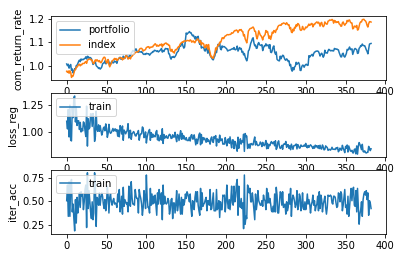

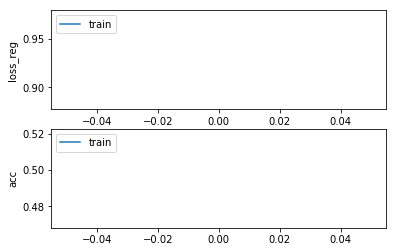

Epochs :  0 Iterations :  383 Loss :  0.9285555772930773 ACC :  0.4953770678753019 MCC :  0.00503013107601028 Precision :  0.5130660877789203
mode : validation


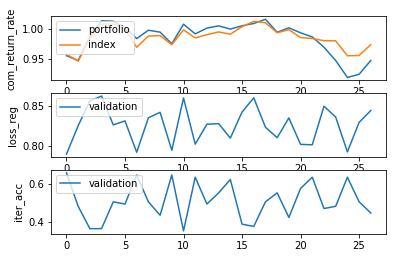

Epochs :  0 Iterations :  27 Loss :  0.826201319694519 ACC :  0.5098039364373242 MCC :  nan Precision :  0.4982415418382044


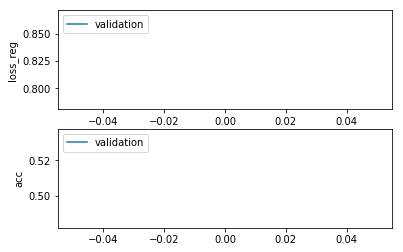

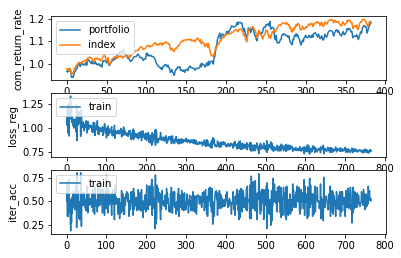

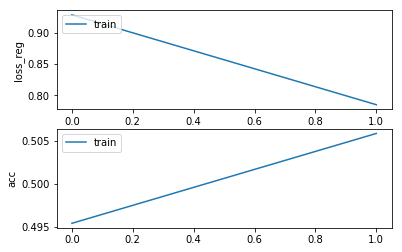

Epochs :  1 Iterations :  766 Loss :  0.785052205657212 ACC :  0.505820933116634 MCC :  0.010494852817602767 Precision :  0.5152442552800979
mode : validation


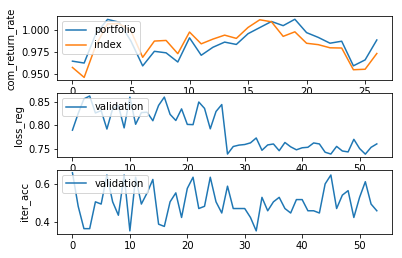

Epochs :  1 Iterations :  27 Loss :  0.7545191954683375 ACC :  0.49847495887014603 MCC :  nan Precision :  0.48906673967010444


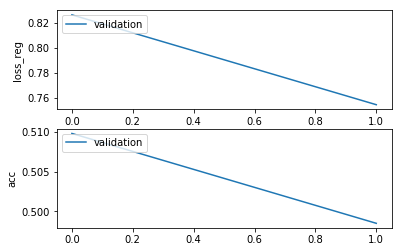

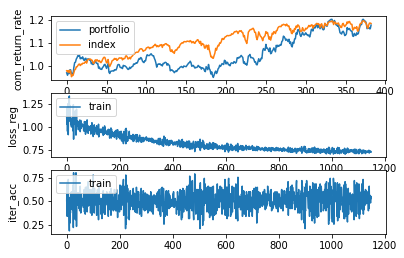

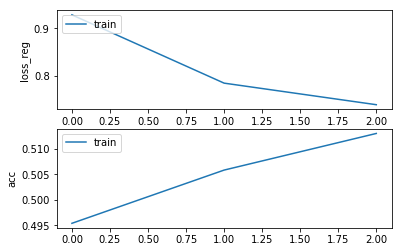

Epochs :  2 Iterations :  1149 Loss :  0.7397236227989197 ACC :  0.5130087705645175 MCC :  0.029471876702451345 Precision :  0.5209243670154567
mode : validation


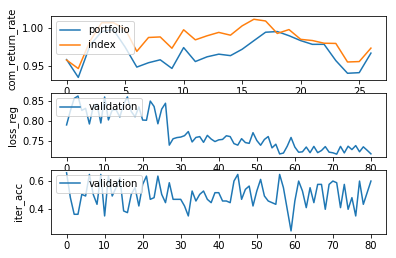

Epochs :  2 Iterations :  27 Loss :  0.7294062376022339 ACC :  0.4971677710612615 MCC :  nan Precision :  0.4937156251873131


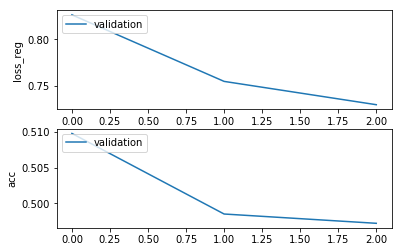

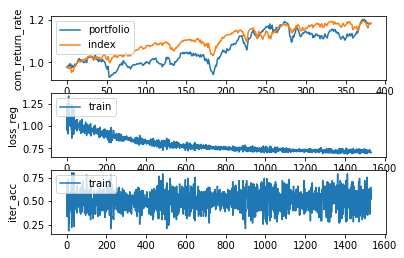

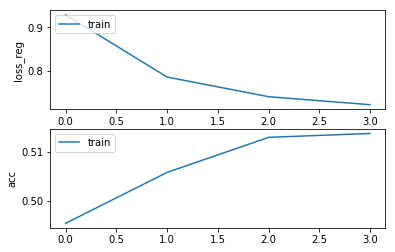

Epochs :  3 Iterations :  1532 Loss :  0.721251941847739 ACC :  0.5138074182966048 MCC :  0.031065656123293792 Precision :  0.5218716645880794
mode : validation


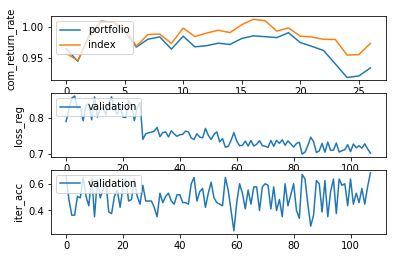

Epochs :  3 Iterations :  27 Loss :  0.717236253950331 ACC :  0.5141612357563443 MCC :  nan Precision :  0.4994137542391265


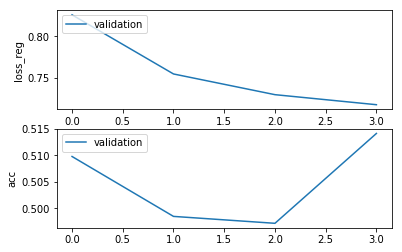

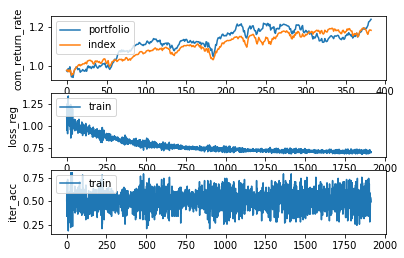

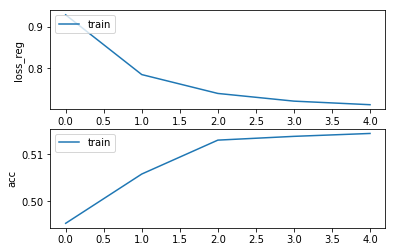

Epochs :  4 Iterations :  1915 Loss :  0.7126719025656698 ACC :  0.5144217635648369 MCC :  0.027810265368316323 Precision :  0.5194231326018239
mode : validation


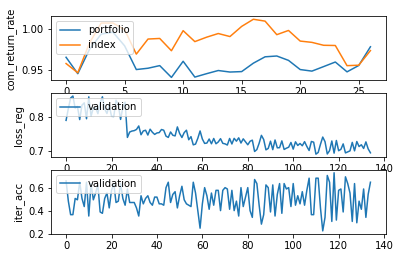

Epochs :  4 Iterations :  27 Loss :  0.71148548523585 ACC :  0.49891069034735364 MCC :  nan Precision :  0.4914039126424878


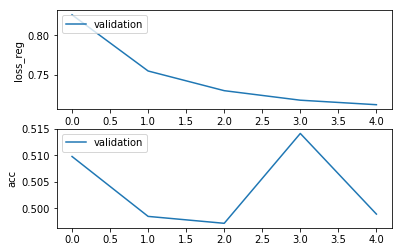

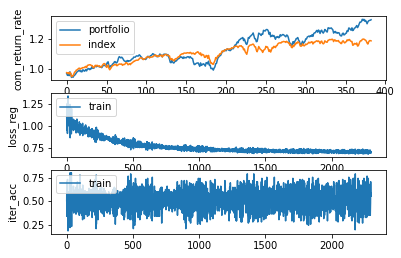

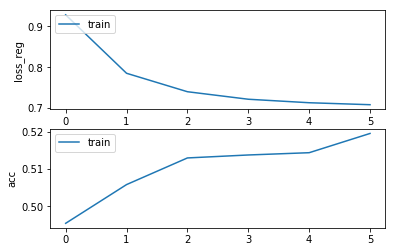

Epochs :  5 Iterations :  2298 Loss :  0.7078294265363608 ACC :  0.5196129785116286 MCC :  0.03450065612651325 Precision :  0.5217694144540371
mode : validation


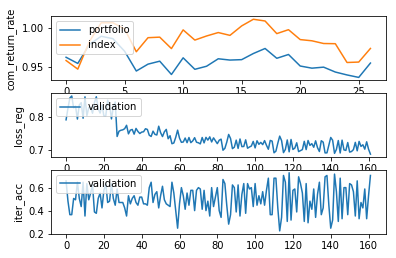

Epochs :  5 Iterations :  27 Loss :  0.708659686424114 ACC :  0.5028322587410609 MCC :  nan Precision :  0.4944102532333798


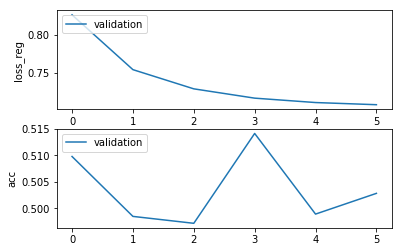

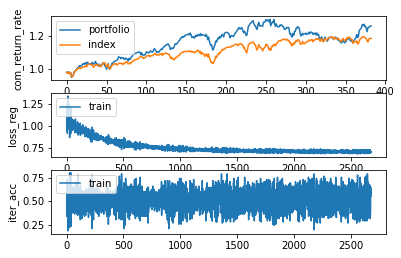

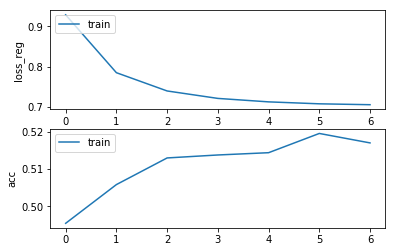

Epochs :  6 Iterations :  2681 Loss :  0.7056318709806736 ACC :  0.5170634471405269 MCC :  0.037007087761385477 Precision :  0.5221594923295022
mode : validation


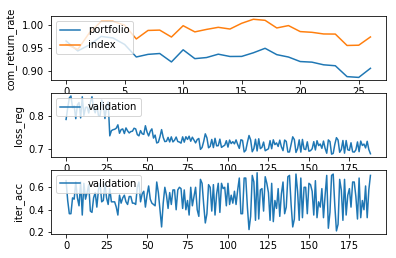

Epochs :  6 Iterations :  27 Loss :  0.7066044741206698 ACC :  0.49324620211565934 MCC :  nan Precision :  0.49212963465187287


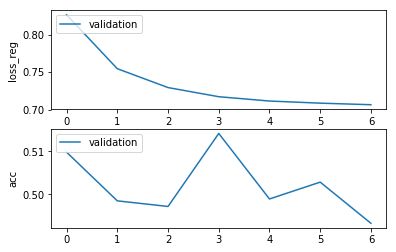

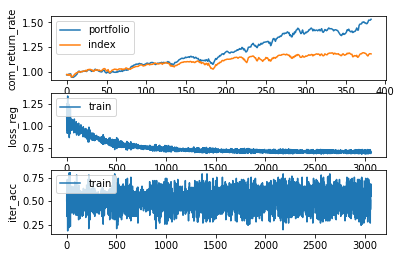

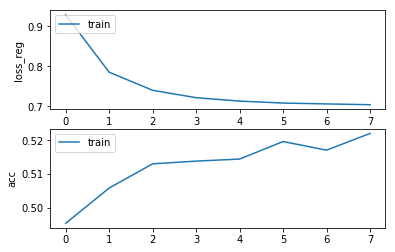

Epochs :  7 Iterations :  3064 Loss :  0.7036736095543007 ACC :  0.5220089239255566 MCC :  0.03953981866975565 Precision :  0.5230477768976446
mode : validation


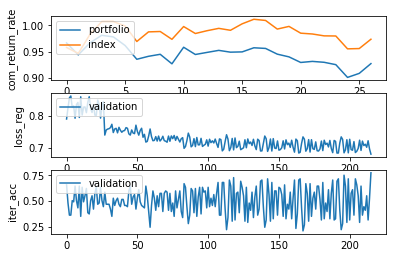

Epochs :  7 Iterations :  27 Loss :  0.7050824717239097 ACC :  0.5010893394549688 MCC :  nan Precision :  0.49078659023399707


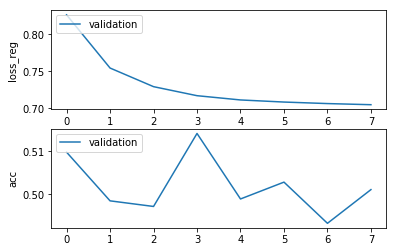

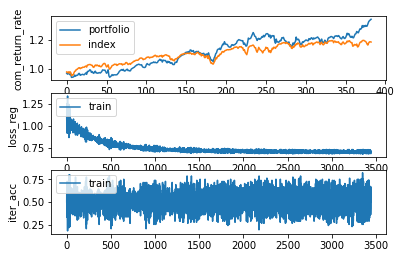

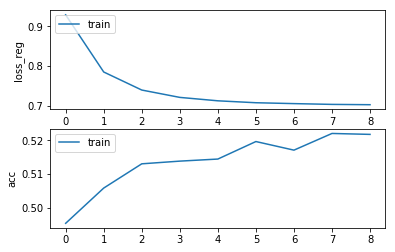

Epochs :  8 Iterations :  3447 Loss :  0.7028882469271867 ACC :  0.5217324687513296 MCC :  0.04630738481688958 Precision :  0.524646988756196
mode : validation


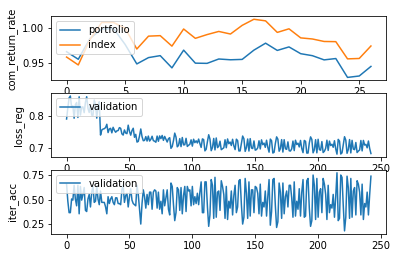

Epochs :  8 Iterations :  27 Loss :  0.7046606253694605 ACC :  0.5028322587410609 MCC :  nan Precision :  0.4951938058215159


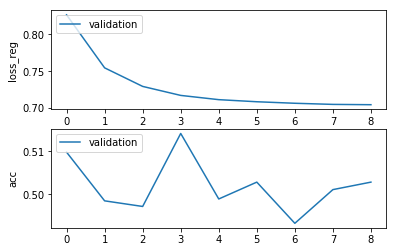

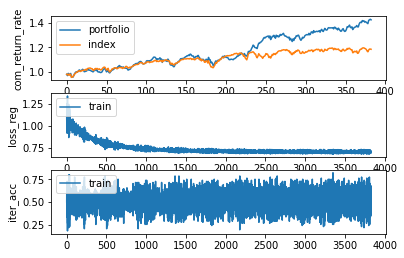

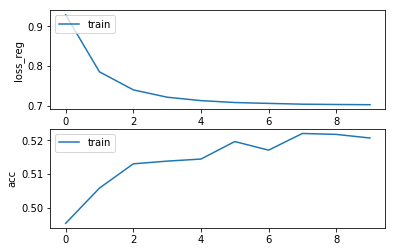

Epochs :  9 Iterations :  3830 Loss :  0.7023558131085986 ACC :  0.5206573647945419 MCC :  0.040823195876757916 Precision :  0.5228598743200535
mode : validation


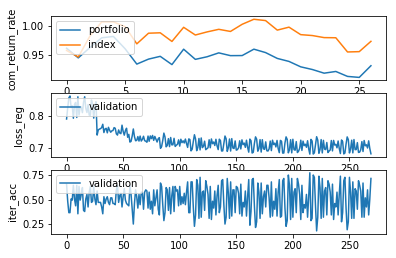

Epochs :  9 Iterations :  27 Loss :  0.704196901233108 ACC :  0.49891069145114336 MCC :  nan Precision :  0.49483059332878504


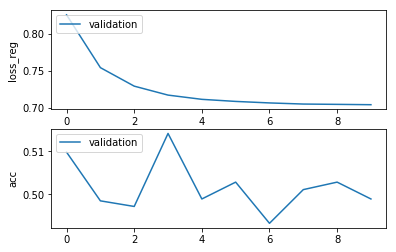

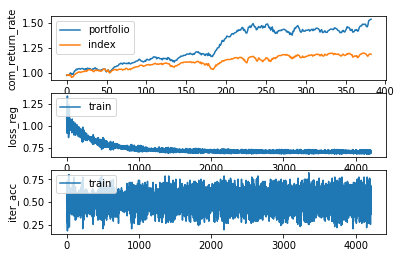

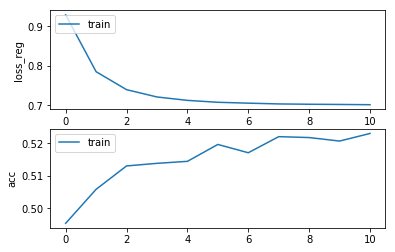

Epochs :  10 Iterations :  4213 Loss :  0.7017319501224448 ACC :  0.5229918756777562 MCC :  0.04420820154221096 Precision :  0.5243132369344757
mode : validation


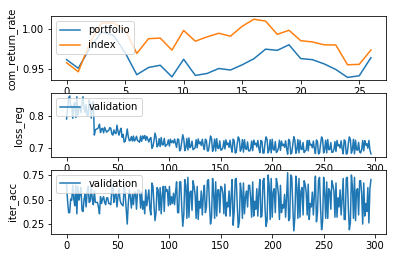

Epochs :  10 Iterations :  27 Loss :  0.7042577112162555 ACC :  0.4958605810447975 MCC :  nan Precision :  0.49209110466418443


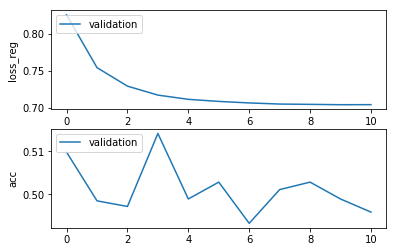

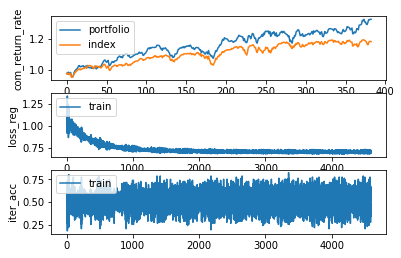

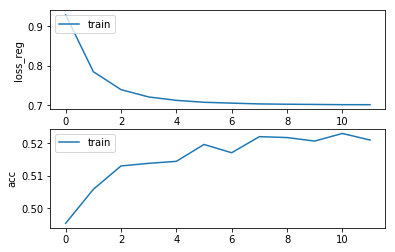

Epochs :  11 Iterations :  4596 Loss :  0.7016837657587335 ACC :  0.5209645375648304 MCC :  0.03885506269629612 Precision :  0.5225443538307522
mode : validation


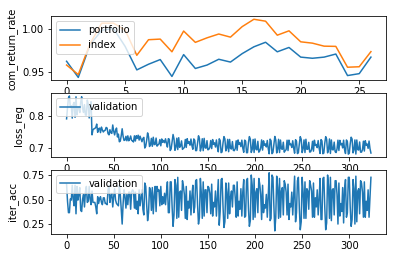

Epochs :  11 Iterations :  27 Loss :  0.7032821509573195 ACC :  0.5006536090815509 MCC :  nan Precision :  0.4944736767836191


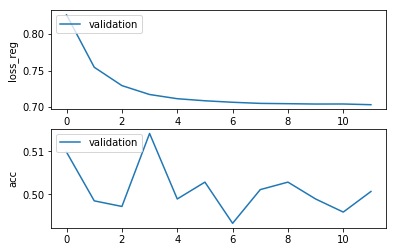

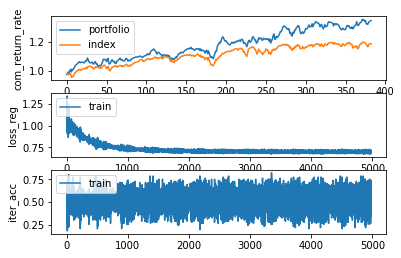

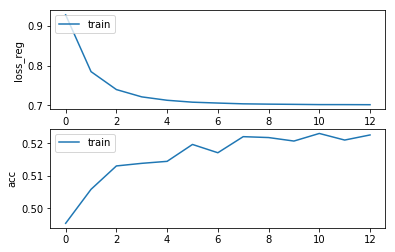

Epochs :  12 Iterations :  4979 Loss :  0.701467613482911 ACC :  0.5225311173393583 MCC :  0.04564611349916256 Precision :  0.5247813735556042
mode : validation


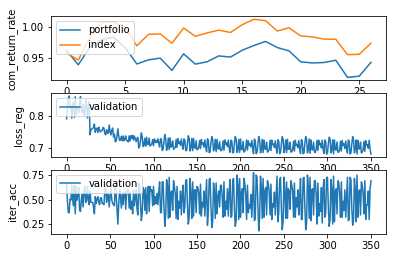

Epochs :  12 Iterations :  27 Loss :  0.7033463959340696 ACC :  0.49803923070430756 MCC :  nan Precision :  0.4926106855273247


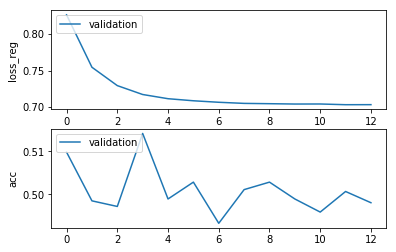

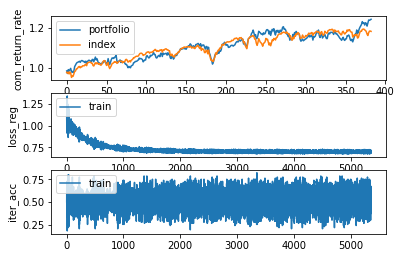

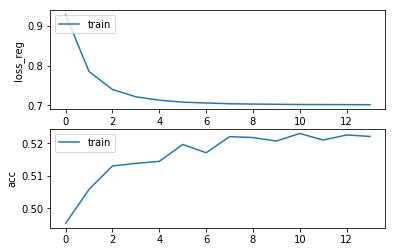

Epochs :  13 Iterations :  5362 Loss :  0.7012763684785709 ACC :  0.5220703581839256 MCC :  0.04631163896193397 Precision :  0.524531963346988
mode : validation


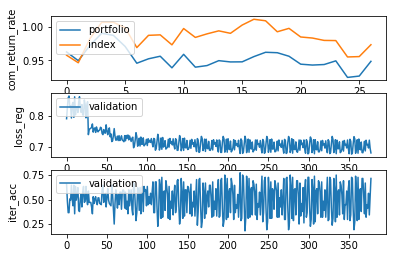

Epochs :  13 Iterations :  27 Loss :  0.7033510539266798 ACC :  0.5002178798119227 MCC :  nan Precision :  0.4922516641241533


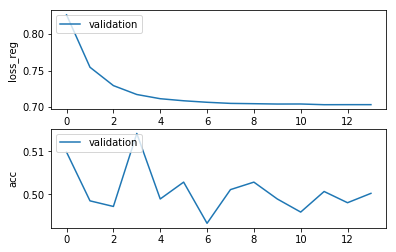

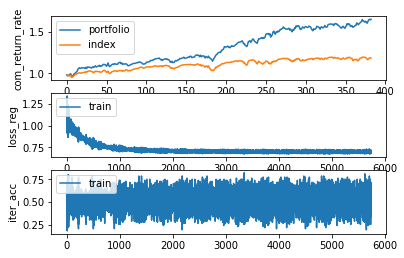

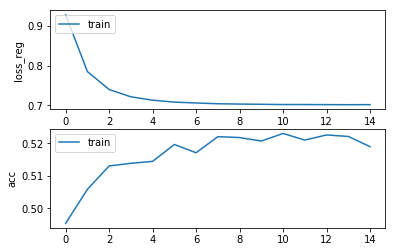

Epochs :  14 Iterations :  5745 Loss :  0.701451147349634 ACC :  0.5189371990628404 MCC :  0.03743655110834599 Precision :  0.5223237952903186
mode : validation


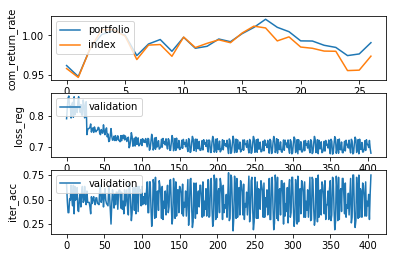

Epochs :  14 Iterations :  27 Loss :  0.7035871457170557 ACC :  0.49760350088278454 MCC :  nan Precision :  0.4899432246607763


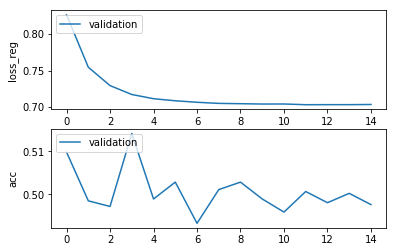

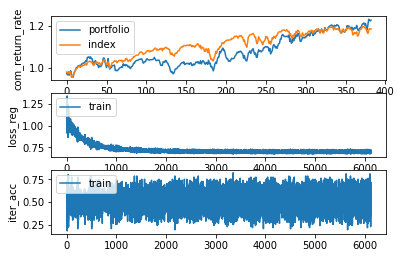

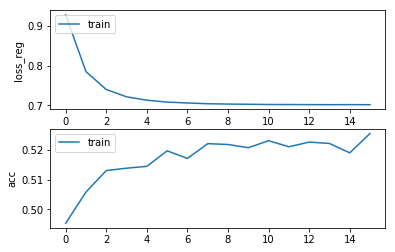

Epochs :  15 Iterations :  6128 Loss :  0.7012467392119665 ACC :  0.5254185383764944 MCC :  0.04605818111294462 Precision :  0.5246732722452353
mode : validation


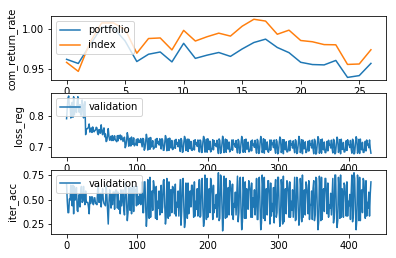

Epochs :  15 Iterations :  27 Loss :  0.7034113583741365 ACC :  0.5006536096334457 MCC :  nan Precision :  0.4928369647650807


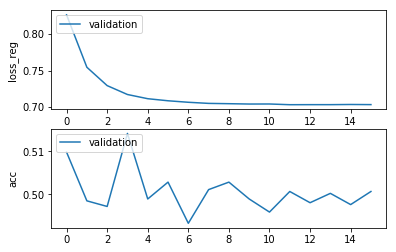

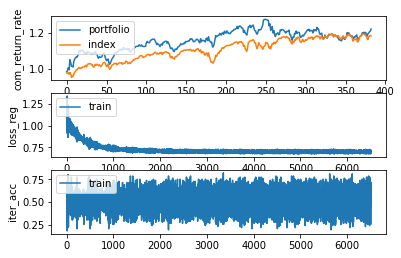

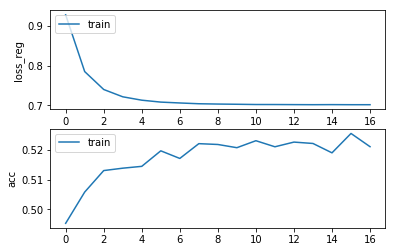

Epochs :  16 Iterations :  6511 Loss :  0.7012497977239345 ACC :  0.5209952555499563 MCC :  0.039913112605866 Precision :  0.5228909655539781
mode : validation


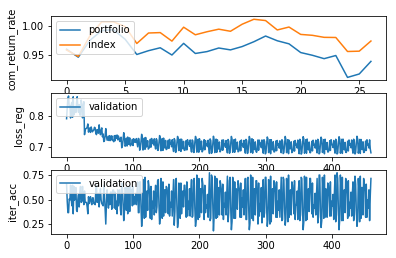

Epochs :  16 Iterations :  27 Loss :  0.7036200298203362 ACC :  0.49891069034735364 MCC :  nan Precision :  0.4942171318387544


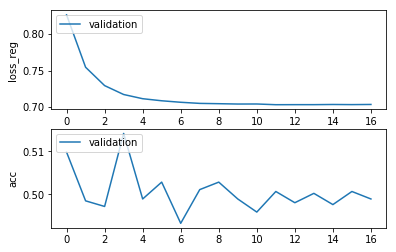

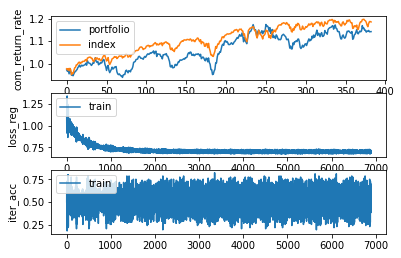

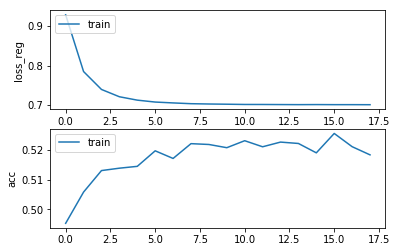

Epochs :  17 Iterations :  6894 Loss :  0.7011212026481529 ACC :  0.5182614194973331 MCC :  0.035148333648691445 Precision :  0.5218301024385205
mode : validation


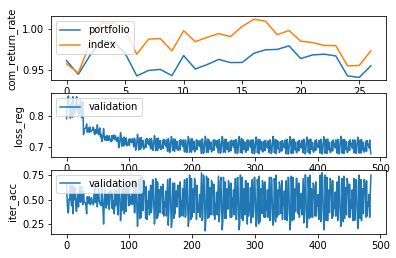

Epochs :  17 Iterations :  27 Loss :  0.7030418338599028 ACC :  0.49891069034735364 MCC :  nan Precision :  0.49346307651312266


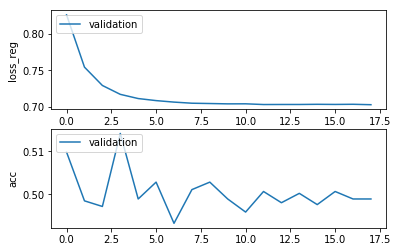

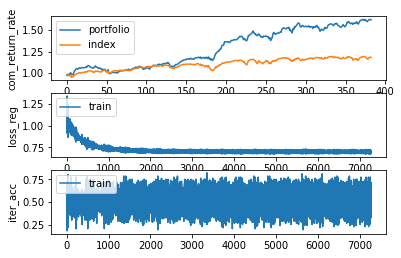

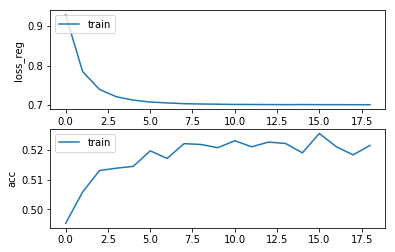

Epochs :  18 Iterations :  7277 Loss :  0.7011057451250658 ACC :  0.5214252962533861 MCC :  0.042206048990834466 Precision :  0.5234033205150079
mode : validation


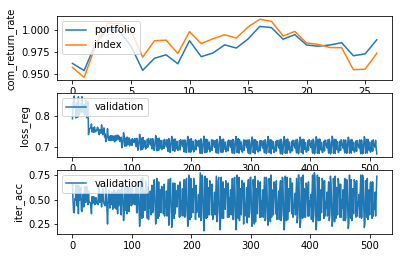

Epochs :  18 Iterations :  27 Loss :  0.7034205374894319 ACC :  0.49629631141821545 MCC :  nan Precision :  0.48928213478238497


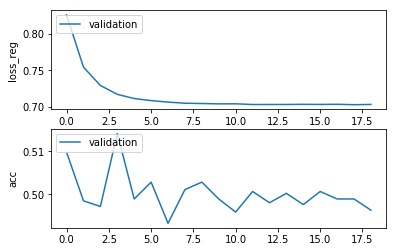

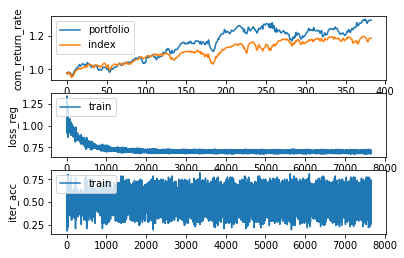

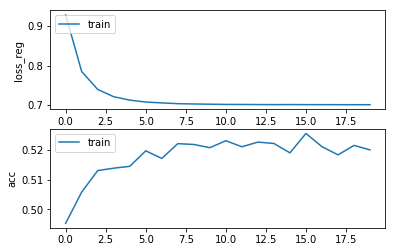

Epochs :  19 Iterations :  7660 Loss :  0.7010682900642913 ACC :  0.5199201508539464 MCC :  0.033318960899973465 Precision :  0.5217895952610216
mode : validation


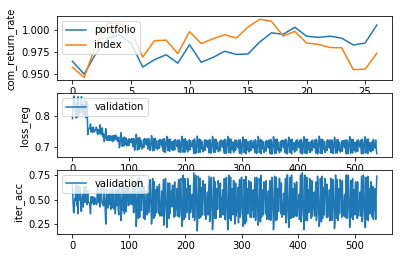

Epochs :  19 Iterations :  27 Loss :  0.7034300808553342 ACC :  0.4962963108663206 MCC :  nan Precision :  0.49302653375047223


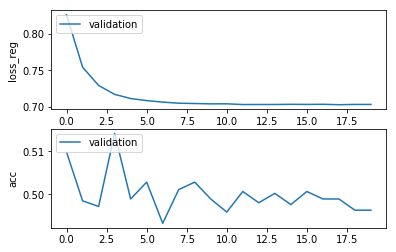

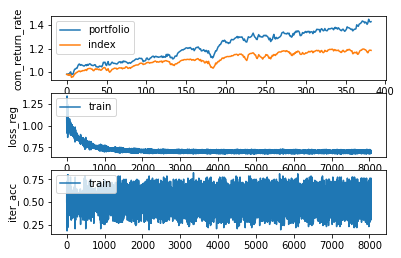

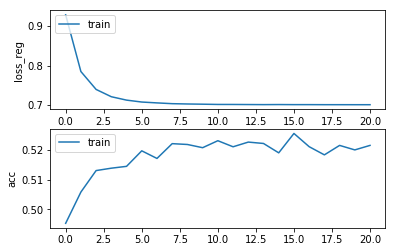

Epochs :  20 Iterations :  8043 Loss :  0.7010649627867318 ACC :  0.521425296058854 MCC :  0.03616552827812916 Precision :  0.5220237921135544
mode : validation


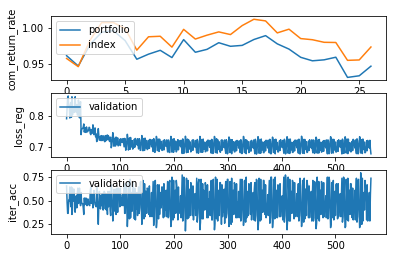

Epochs :  20 Iterations :  27 Loss :  0.703416989909278 ACC :  0.49455339102833357 MCC :  nan Precision :  0.4916167002585199


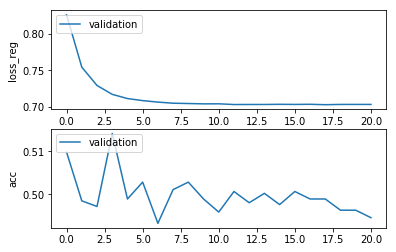

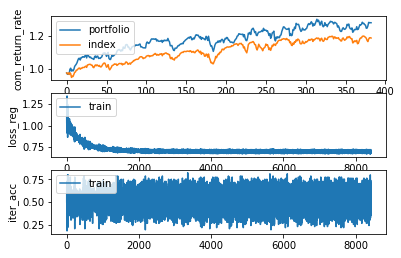

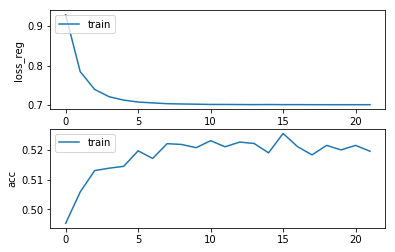

Epochs :  21 Iterations :  8426 Loss :  0.7011230953679695 ACC :  0.5194593919708586 MCC :  0.03839583789085357 Precision :  0.5224174262503498
mode : validation


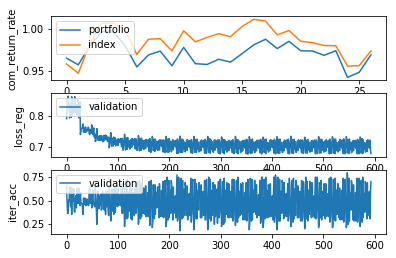

Epochs :  21 Iterations :  27 Loss :  0.7034067820619654 ACC :  0.49803923070430756 MCC :  nan Precision :  0.49154249399348543


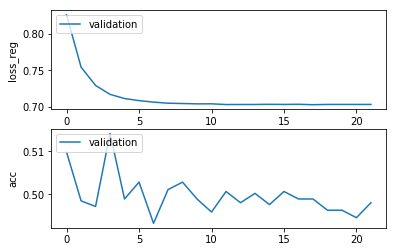

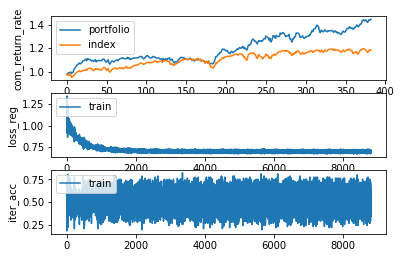

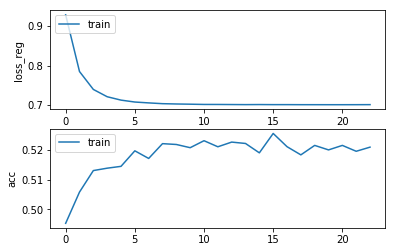

Epochs :  22 Iterations :  8809 Loss :  0.7012399087998015 ACC :  0.5208416685423092 MCC :  0.04041269319098535 Precision :  0.5232004078674098
mode : validation


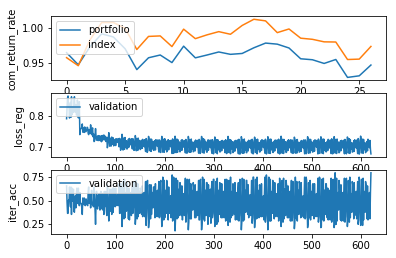

Epochs :  22 Iterations :  27 Loss :  0.7034516157927336 ACC :  0.49760349922709995 MCC :  nan Precision :  0.4937730782009937


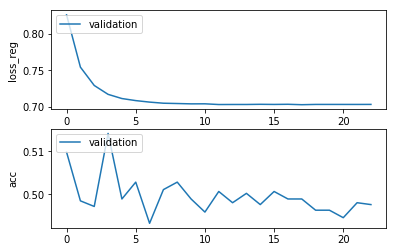

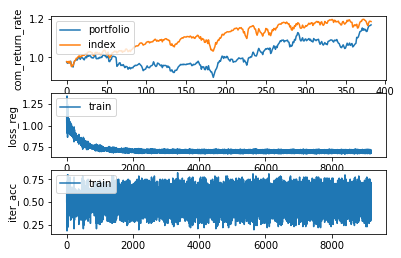

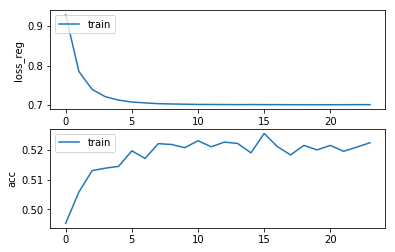

Epochs :  23 Iterations :  9192 Loss :  0.7011624612011423 ACC :  0.5223160968514708 MCC :  0.045291211392381535 Precision :  0.524019279631521
mode : validation


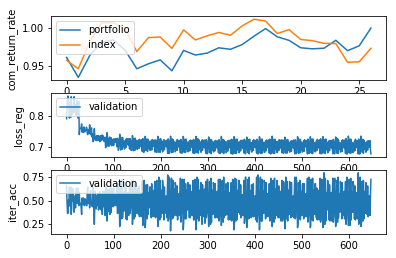

Epochs :  23 Iterations :  27 Loss :  0.7033064299159579 ACC :  0.4958605810447975 MCC :  nan Precision :  0.48837321279225526


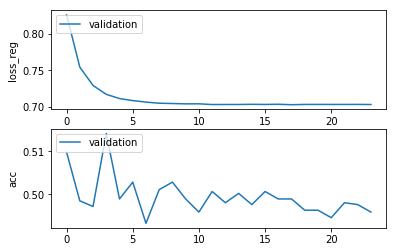

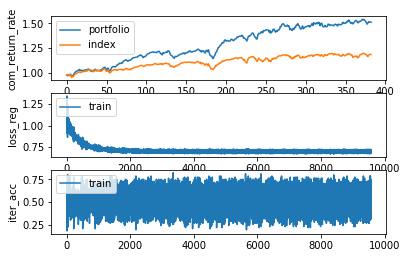

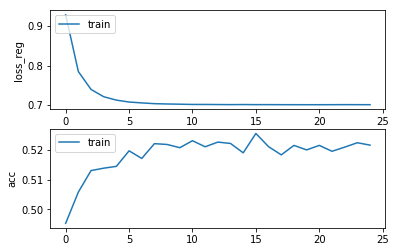

Epochs :  24 Iterations :  9575 Loss :  0.7010972051645383 ACC :  0.5215174476409394 MCC :  0.03941164557778279 Precision :  0.5227113044905833
mode : validation


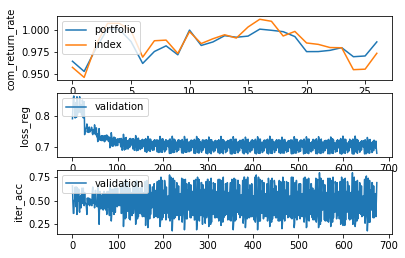

Epochs :  24 Iterations :  27 Loss :  0.7028431318424366 ACC :  0.4962963103144257 MCC :  nan Precision :  0.4912881851196289


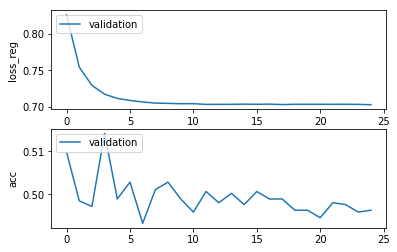

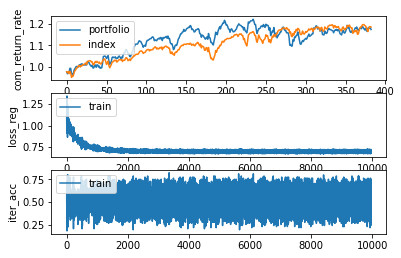

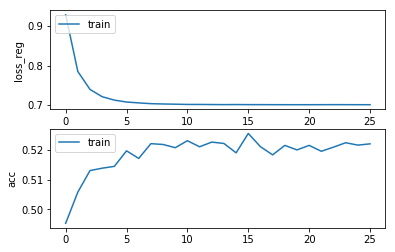

Epochs :  25 Iterations :  9958 Loss :  0.7010525606630987 ACC :  0.5219474888112464 MCC :  0.040478633353322524 Precision :  0.5229988019018588
mode : validation


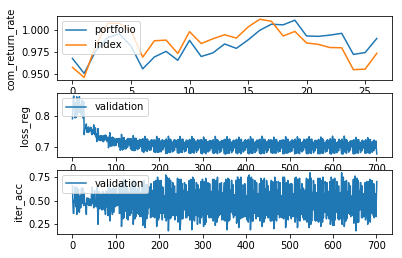

Epochs :  25 Iterations :  27 Loss :  0.7030544104399504 ACC :  0.49978214999039966 MCC :  nan Precision :  0.4923691472245587


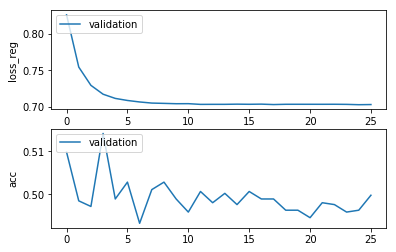

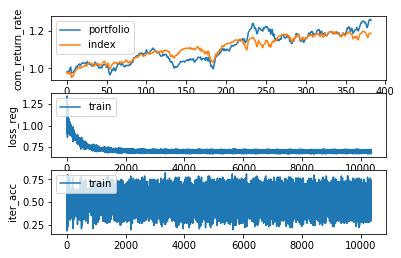

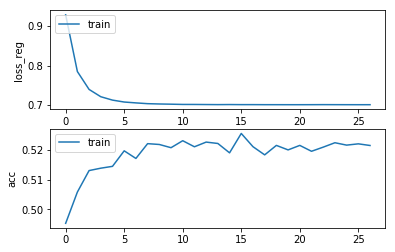

Epochs :  26 Iterations :  10341 Loss :  0.7010758358878193 ACC :  0.5213945785016989 MCC :  0.041770464947383956 Precision :  0.5234530502030572
mode : validation


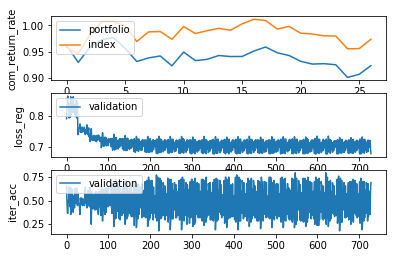

Epochs :  26 Iterations :  27 Loss :  0.7032443395367375 ACC :  0.49803923070430756 MCC :  nan Precision :  0.49383191309041446


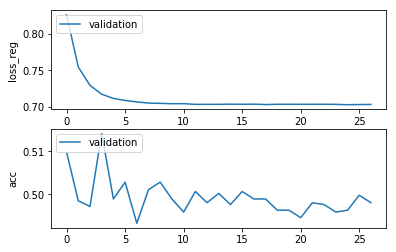

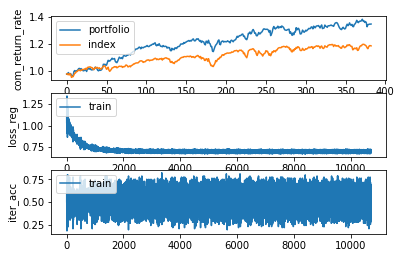

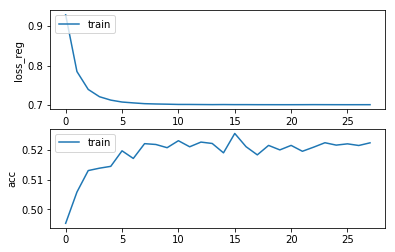

Epochs :  27 Iterations :  10724 Loss :  0.701100511899505 ACC :  0.5222853794888479 MCC :  0.046494959863012185 Precision :  0.5245237965331299
mode : validation


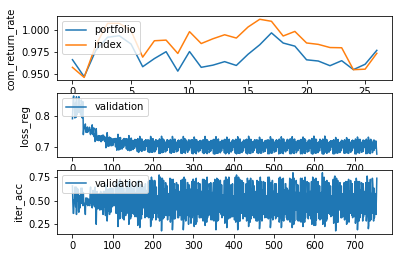

Epochs :  27 Iterations :  27 Loss :  0.703265560997857 ACC :  0.4984749599739357 MCC :  nan Precision :  0.49123569012240126


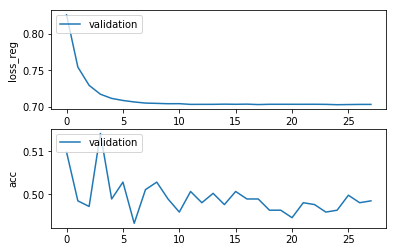

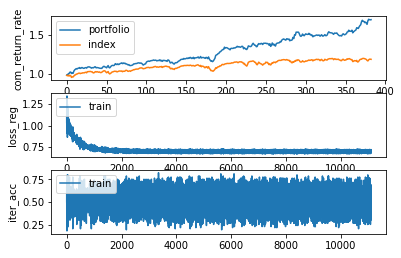

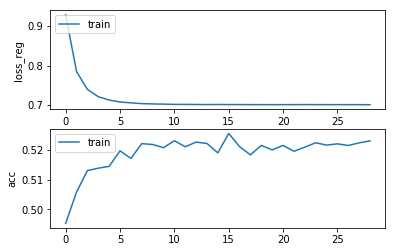

Epochs :  28 Iterations :  11107 Loss :  0.7009162025103058 ACC :  0.5229304418084516 MCC :  0.04392412733532824 Precision :  0.5246038971512575
mode : validation


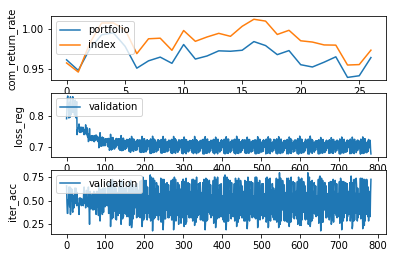

Epochs :  28 Iterations :  27 Loss :  0.7033041075423911 ACC :  0.4980392301524127 MCC :  nan Precision :  0.4920381486967758


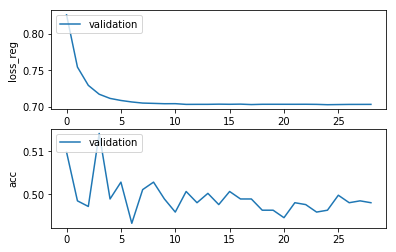

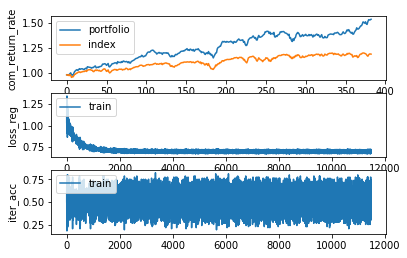

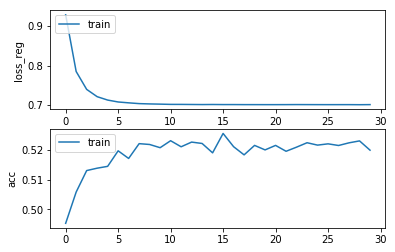

Epochs :  29 Iterations :  11490 Loss :  0.7011478029716731 ACC :  0.5198279995831123 MCC :  0.03331814900128166 Precision :  0.5215747419151407
mode : validation


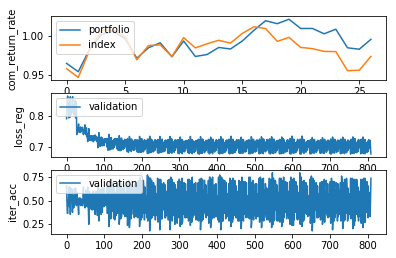

Epochs :  29 Iterations :  27 Loss :  0.7030440017029091 ACC :  0.5015250692764918 MCC :  nan Precision :  0.4927616674039099


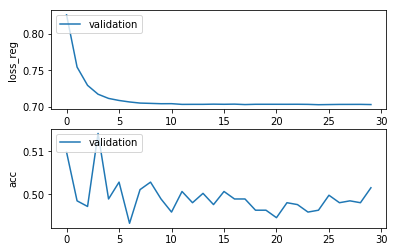

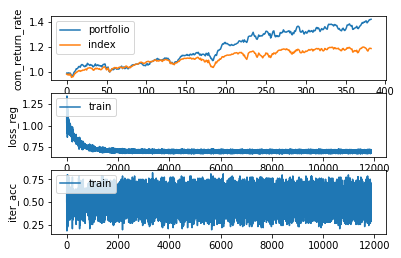

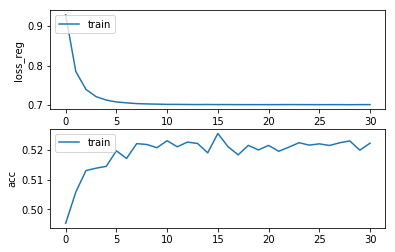

Epochs :  30 Iterations :  11873 Loss :  0.7011164470378786 ACC :  0.522162509960543 MCC :  0.04257028950767363 Precision :  0.5233848133311648
mode : validation


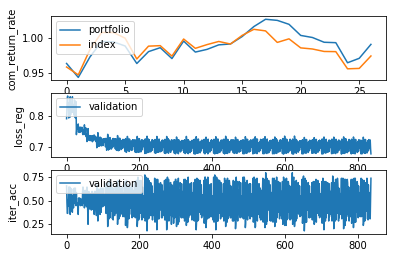

Epochs :  30 Iterations :  27 Loss :  0.7028920893315915 ACC :  0.5023965289195379 MCC :  nan Precision :  0.49199732227457893


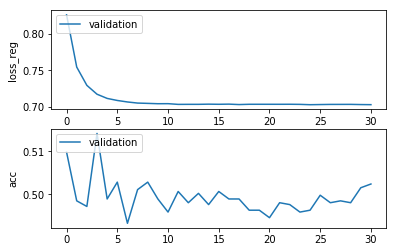

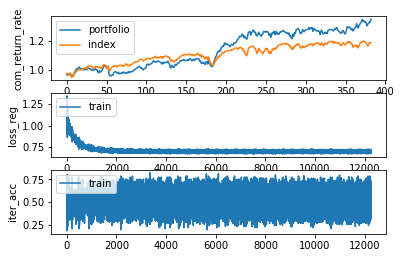

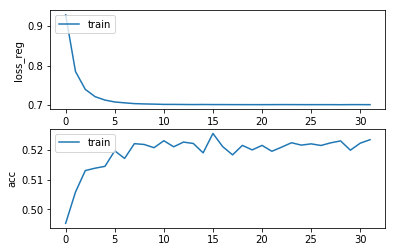

Epochs :  31 Iterations :  12256 Loss :  0.701030169392379 ACC :  0.5233297658106677 MCC :  0.04479701118984481 Precision :  0.5247101562763942
mode : validation


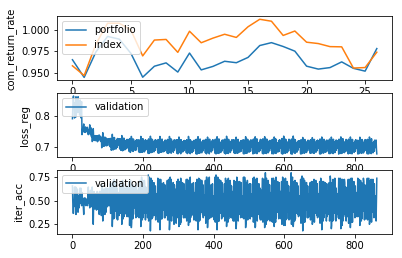

Epochs :  31 Iterations :  27 Loss :  0.7030613643151743 ACC :  0.49934642016887665 MCC :  nan Precision :  0.4918348667798219


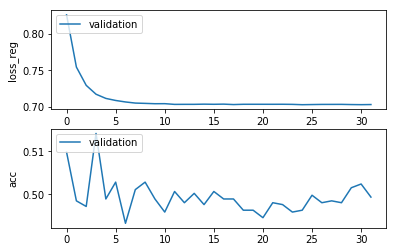

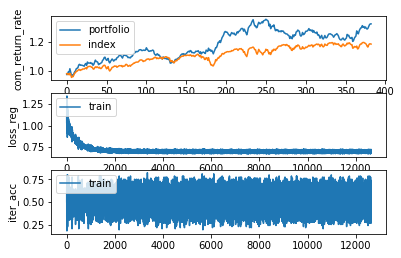

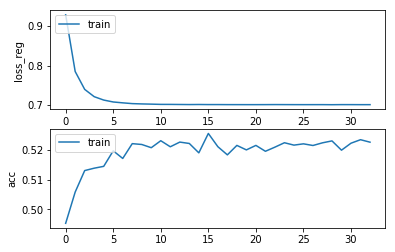

Epochs :  32 Iterations :  12639 Loss :  0.7010479220833542 ACC :  0.5225003993153261 MCC :  0.04322163965285564 Precision :  0.5237480335705974
mode : validation


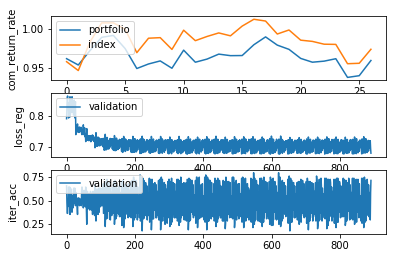

Epochs :  32 Iterations :  27 Loss :  0.7035994463496738 ACC :  0.5023965289195379 MCC :  nan Precision :  0.49578363558760397


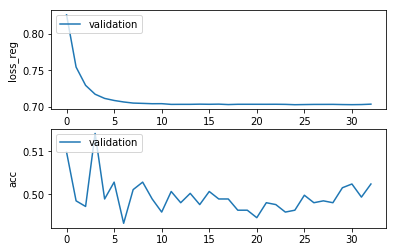

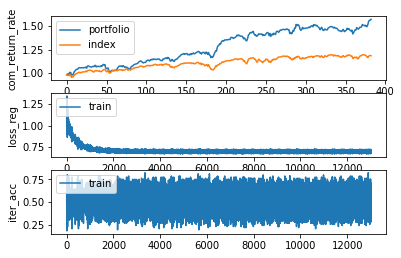

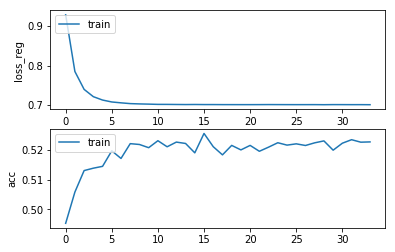

Epochs :  33 Iterations :  13022 Loss :  0.7009026349057728 ACC :  0.5225925519867914 MCC :  0.04203504171874739 Precision :  0.5237516999371136
mode : validation


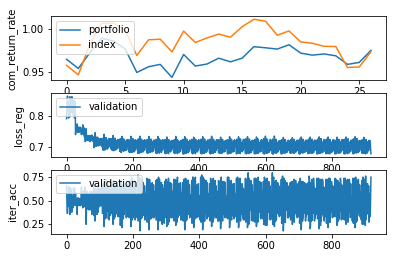

Epochs :  33 Iterations :  27 Loss :  0.7029257637483103 ACC :  0.49847495887014603 MCC :  nan Precision :  0.49285571580683746


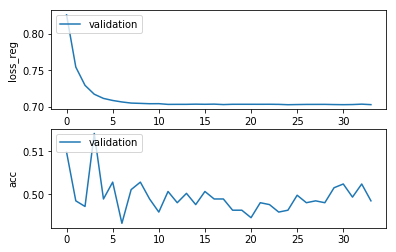

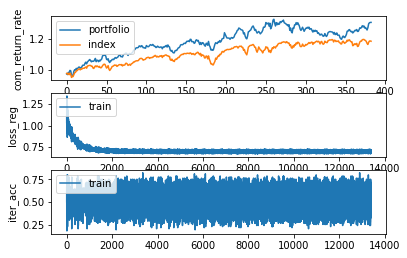

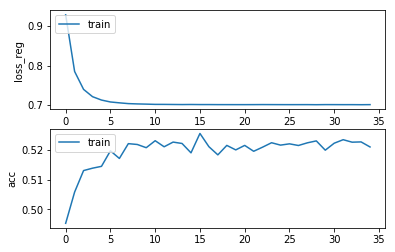

Epochs :  34 Iterations :  13405 Loss :  0.7010861194787387 ACC :  0.5209031028784908 MCC :  0.04086924389134801 Precision :  0.5234077065288243
mode : validation


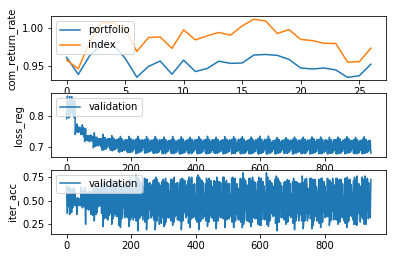

Epochs :  34 Iterations :  27 Loss :  0.7035376120496679 ACC :  0.5054466382220939 MCC :  nan Precision :  0.4952883547930806


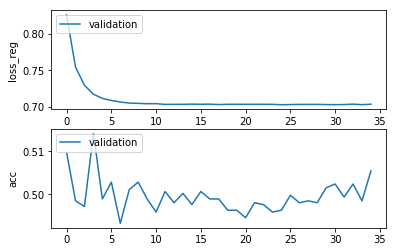

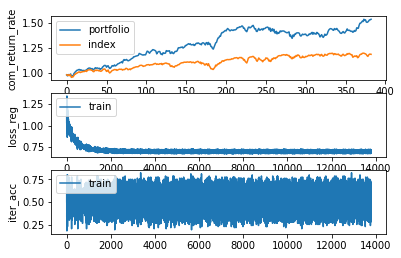

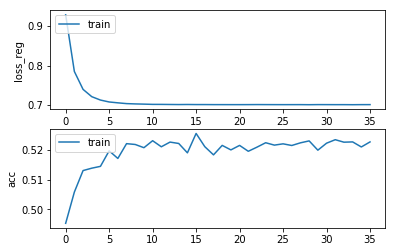

Epochs :  35 Iterations :  13788 Loss :  0.7011156231553997 ACC :  0.522592551947885 MCC :  0.04115968999238904 Precision :  0.5234355852445564
mode : validation


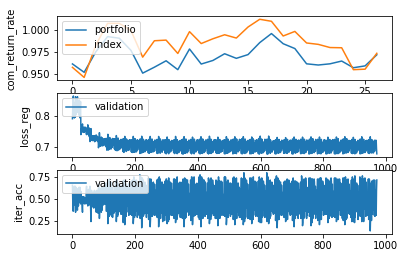

Epochs :  35 Iterations :  27 Loss :  0.7031275806603609 ACC :  0.49847496052583057 MCC :  nan Precision :  0.493665789840398


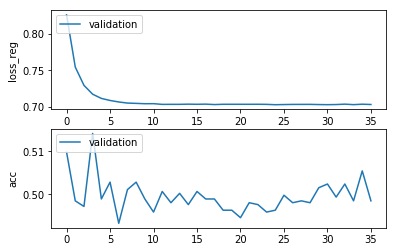

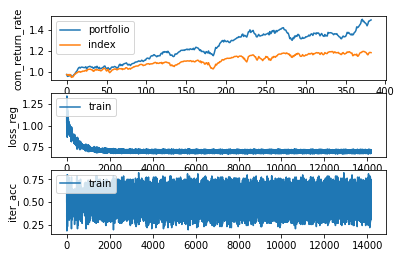

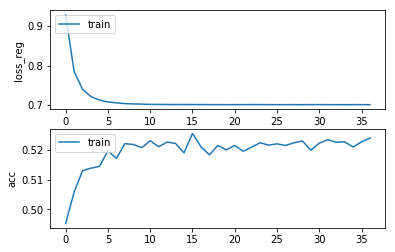

Epochs :  36 Iterations :  14171 Loss :  0.7009272575378418 ACC :  0.5239133937940896 MCC :  0.04363143118873467 Precision :  0.524801101700911
mode : validation


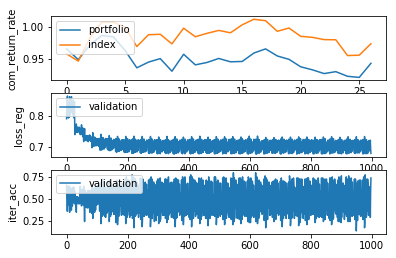

Epochs :  36 Iterations :  27 Loss :  0.7028835857356036 ACC :  0.5041394476537351 MCC :  nan Precision :  0.49435657718115383


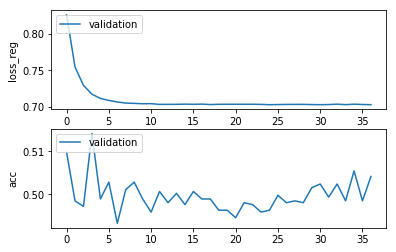

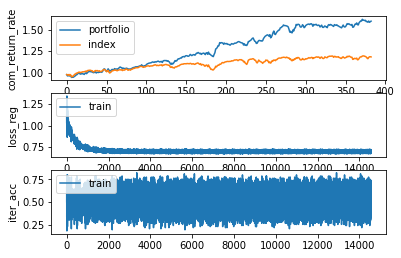

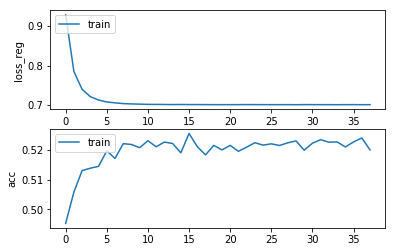

Epochs :  37 Iterations :  14554 Loss :  0.7010312509910245 ACC :  0.51992015081504 MCC :  0.03728580591223244 Precision :  0.5220152568801576
mode : validation


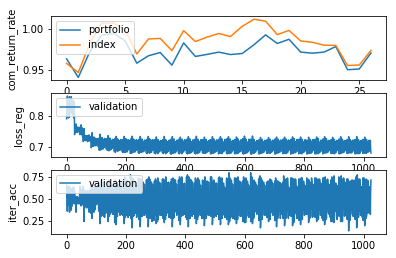

Epochs :  37 Iterations :  27 Loss :  0.7032013800409105 ACC :  0.49934642016887665 MCC :  nan Precision :  0.4929986120098167


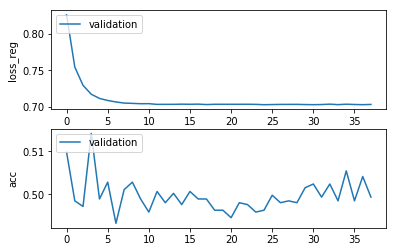

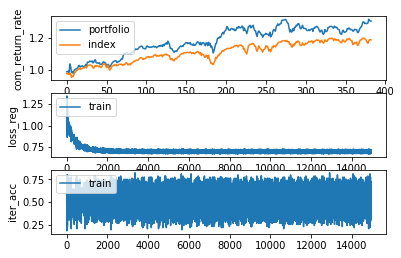

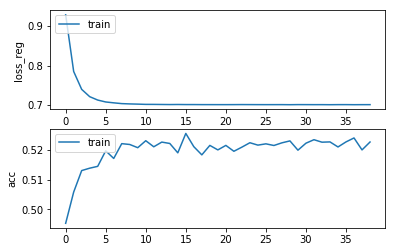

Epochs :  38 Iterations :  14937 Loss :  0.7010477051411222 ACC :  0.5225618343518235 MCC :  0.04539534865009815 Precision :  0.5241731191418735
mode : validation


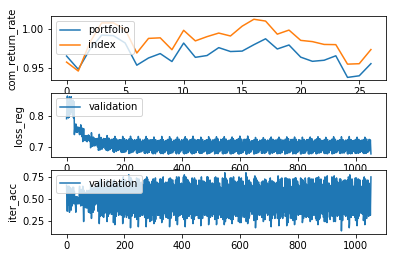

Epochs :  38 Iterations :  27 Loss :  0.7035357466450444 ACC :  0.49891069034735364 MCC :  nan Precision :  0.49094054185681874


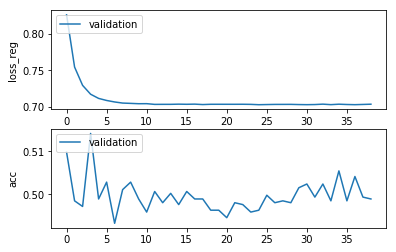

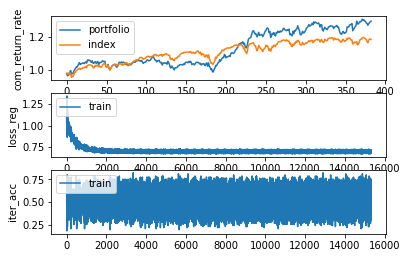

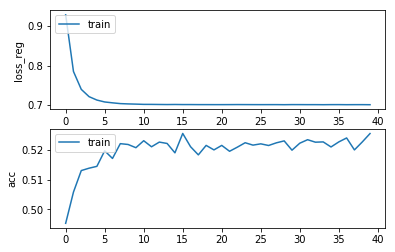

Epochs :  39 Iterations :  15320 Loss :  0.7008880588466754 ACC :  0.525387821519655 MCC :  0.04640609619521363 Precision :  0.5250507098556966
mode : validation


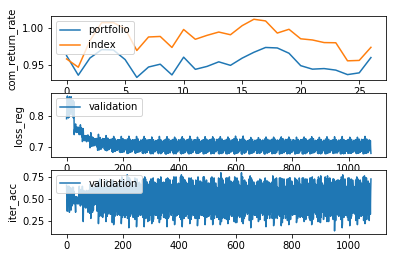

Epochs :  39 Iterations :  27 Loss :  0.703079914605176 ACC :  0.4997821494385048 MCC :  nan Precision :  0.4933685155378448


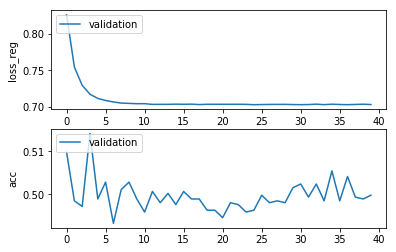

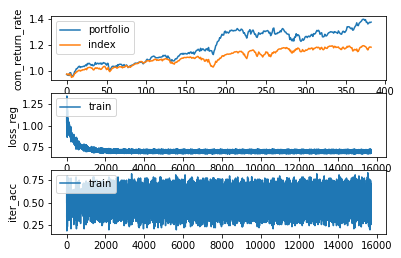

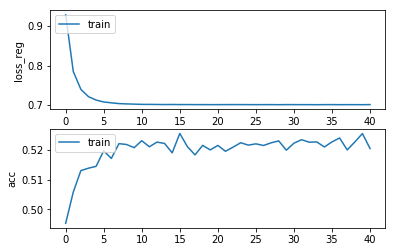

Epochs :  40 Iterations :  15703 Loss :  0.7011898493019781 ACC :  0.5203809097759406 MCC :  0.03928609791545528 Precision :  0.5225106277952929
mode : validation


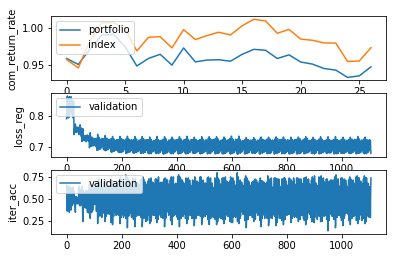

Epochs :  40 Iterations :  27 Loss :  0.7033007431913305 ACC :  0.4967320406878436 MCC :  nan Precision :  0.49250816464148184


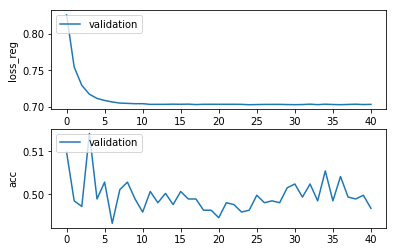

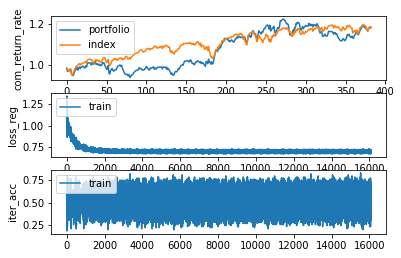

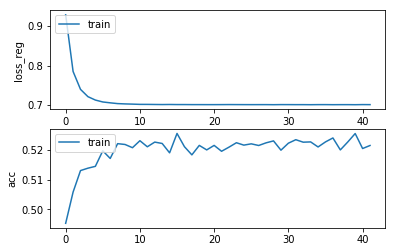

Epochs :  41 Iterations :  16086 Loss :  0.7010719740359652 ACC :  0.5213945791242017 MCC :  0.04121759103175846 Precision :  0.523134107397524
mode : validation


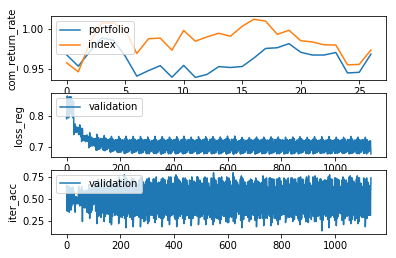

Epochs :  41 Iterations :  27 Loss :  0.7030033093911631 ACC :  0.49803923070430756 MCC :  nan Precision :  0.49229362482825917


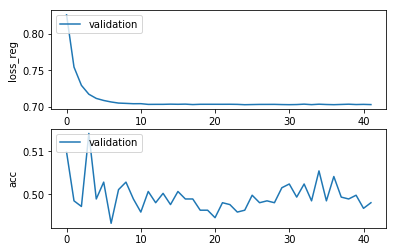

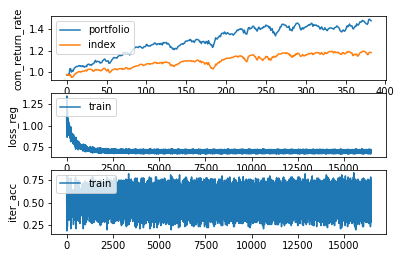

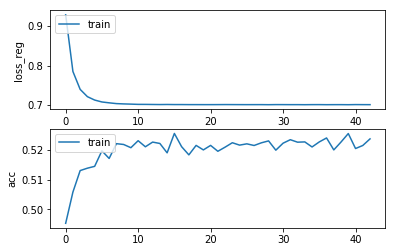

Epochs :  42 Iterations :  16469 Loss :  0.7010013885971149 ACC :  0.5236062206347368 MCC :  0.048403464099811756 Precision :  0.5254360840950093
mode : validation


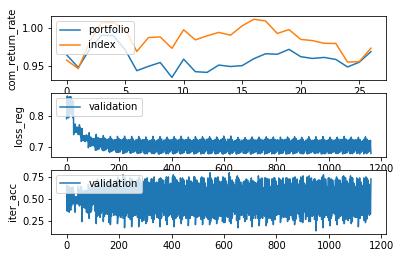

Epochs :  42 Iterations :  27 Loss :  0.7033661714306584 ACC :  0.505446637670199 MCC :  nan Precision :  0.497790660571169


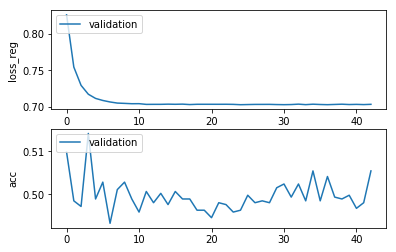

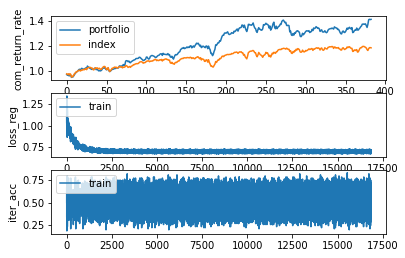

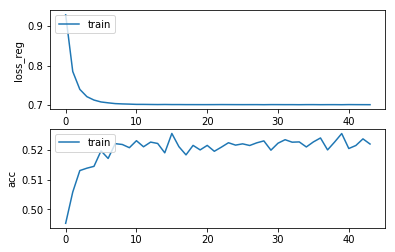

Epochs :  43 Iterations :  16852 Loss :  0.7009365902557074 ACC :  0.521886054864129 MCC :  0.03843279785686963 Precision :  0.5231590816804619
mode : validation


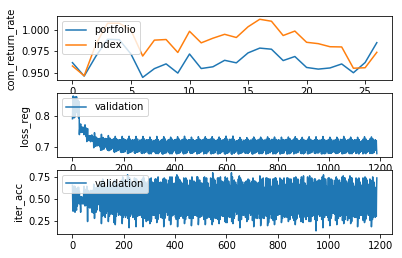

Epochs :  43 Iterations :  27 Loss :  0.7032342111622846 ACC :  0.49629631141821545 MCC :  nan Precision :  0.49736670528848964


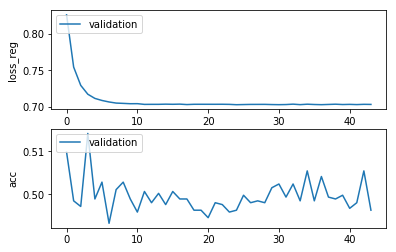

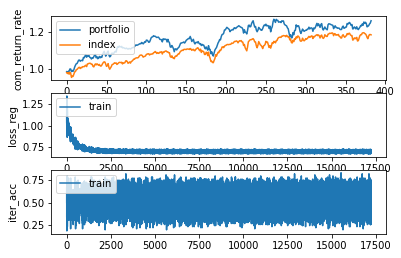

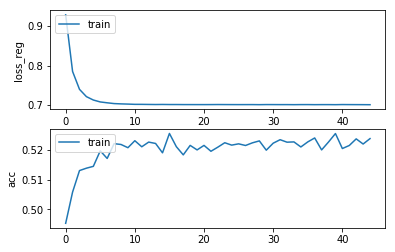

Epochs :  44 Iterations :  17235 Loss :  0.7008133891668394 ACC :  0.5236983724891673 MCC :  0.04518239696901632 Precision :  0.5244406963073631
mode : validation


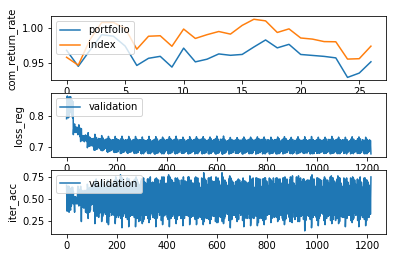

Epochs :  44 Iterations :  27 Loss :  0.703175734590601 ACC :  0.49891069034735364 MCC :  nan Precision :  0.49093662381724074


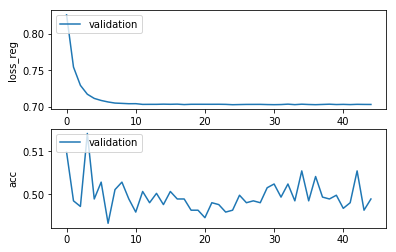

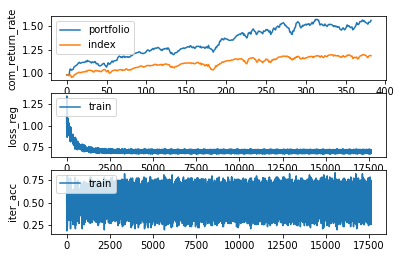

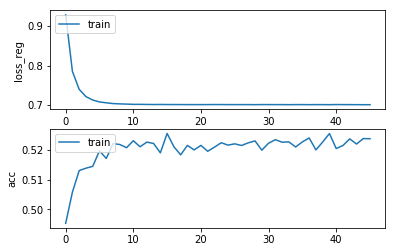

Epochs :  45 Iterations :  17618 Loss :  0.7008518053719642 ACC :  0.5236676553599828 MCC :  0.04381040276110892 Precision :  0.524183178335117
mode : validation


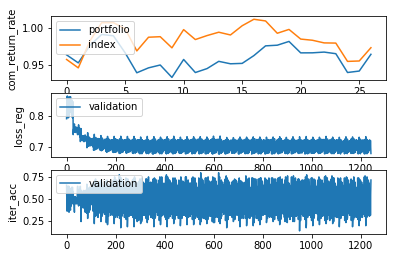

Epochs :  45 Iterations :  27 Loss :  0.7031068868107266 ACC :  0.5063180984170349 MCC :  nan Precision :  0.495055404526216


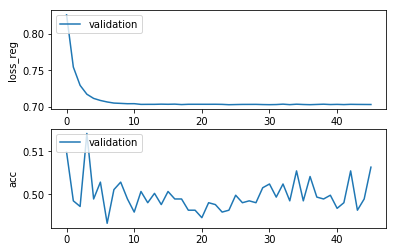

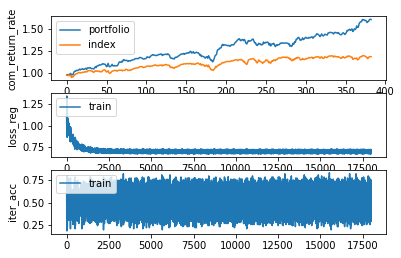

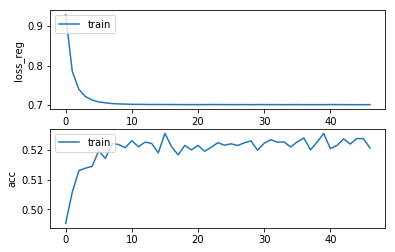

Epochs :  46 Iterations :  18001 Loss :  0.7010030690434708 ACC :  0.5205344961610849 MCC :  0.04249491559477722 Precision :  0.5237187345368743
mode : validation


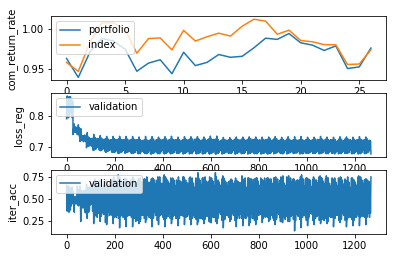

Epochs :  46 Iterations :  27 Loss :  0.7032075700936494 ACC :  0.4971677705093666 MCC :  nan Precision :  0.49174308473313294


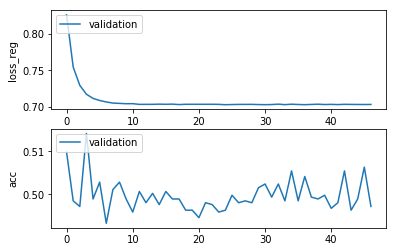

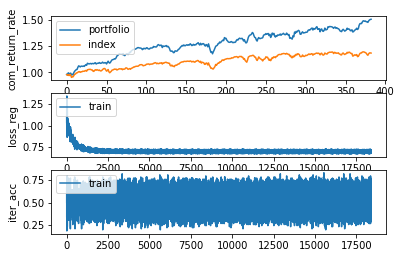

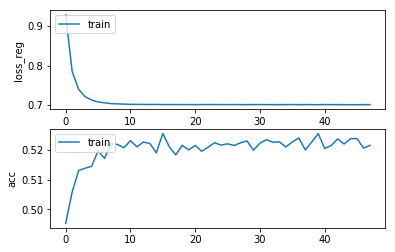

Epochs :  47 Iterations :  18384 Loss :  0.701075764455621 ACC :  0.5214252961366669 MCC :  0.04331518019435261 Precision :  0.5236009230336306
mode : validation


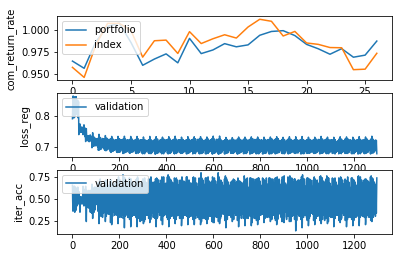

Epochs :  47 Iterations :  27 Loss :  0.7033562417383548 ACC :  0.509368207167696 MCC :  nan Precision :  0.4956429235085293


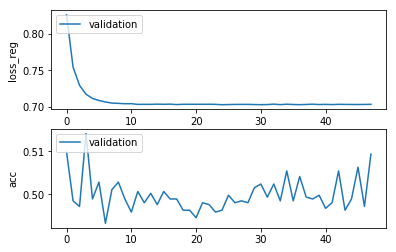

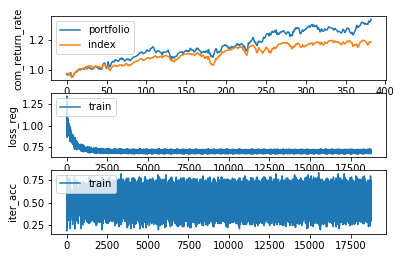

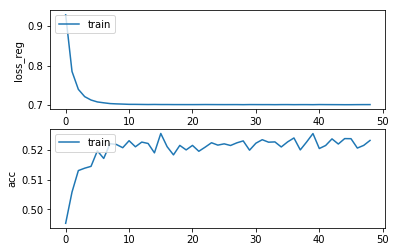

Epochs :  48 Iterations :  18767 Loss :  0.7010917276066215 ACC :  0.523084027571093 MCC :  0.04375351351222592 Precision :  0.524109101657301
mode : validation


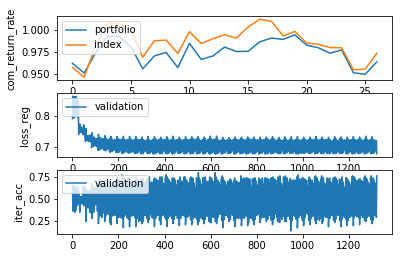

Epochs :  48 Iterations :  27 Loss :  0.7031806486624258 ACC :  0.5010893394549688 MCC :  nan Precision :  0.49408438180883724


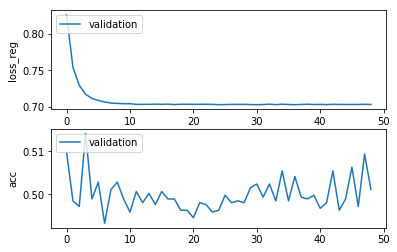

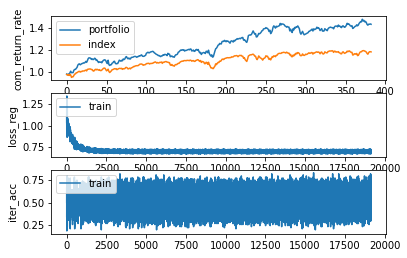

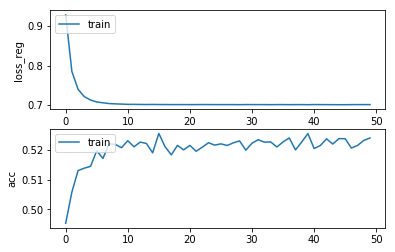

Epochs :  49 Iterations :  19150 Loss :  0.7010824213451256 ACC :  0.5239133931326804 MCC :  0.0478759737564956 Precision :  0.5248737191202668
mode : validation


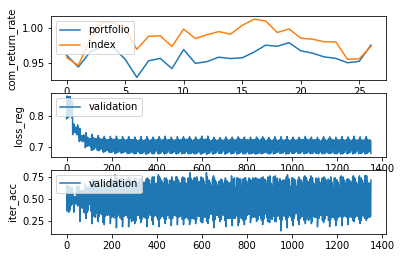

Epochs :  49 Iterations :  27 Loss :  0.7035382169264334 ACC :  0.49847496107772543 MCC :  nan Precision :  0.49295399613954405


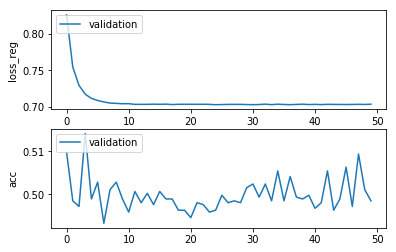

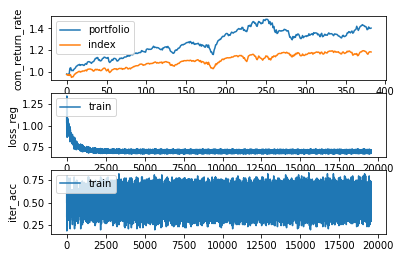

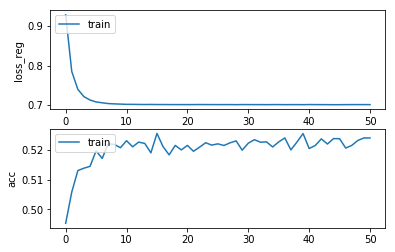

Epochs :  50 Iterations :  19533 Loss :  0.700982940414867 ACC :  0.5239133930548675 MCC :  0.046729649206612496 Precision :  0.5246707717632734
mode : validation


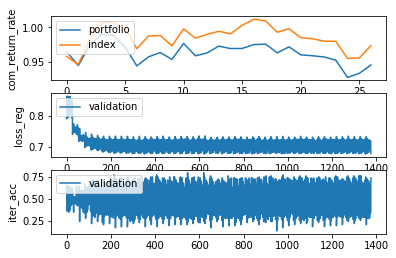

Epochs :  50 Iterations :  27 Loss :  0.7033667983832183 ACC :  0.4976035003308897 MCC :  nan Precision :  0.4923661356722867


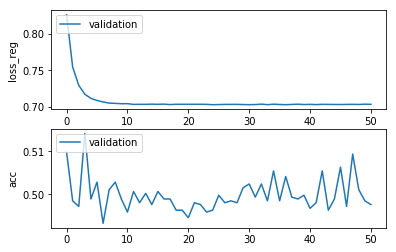

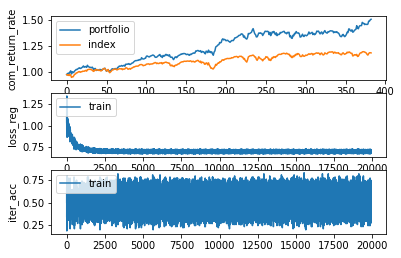

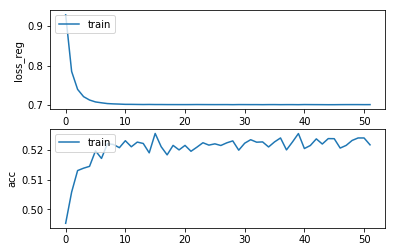

Epochs :  51 Iterations :  19916 Loss :  0.701040525349251 ACC :  0.521609599962247 MCC :  0.0389122461656038 Precision :  0.5227237143906382
mode : validation


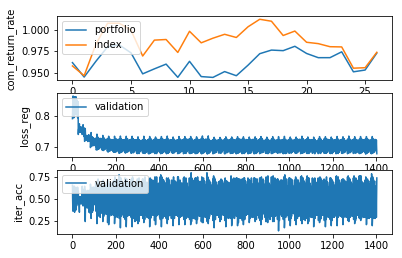

Epochs :  51 Iterations :  27 Loss :  0.7031555264084427 ACC :  0.5019607990980148 MCC :  nan Precision :  0.49395810081451025


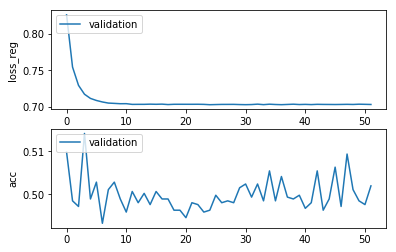

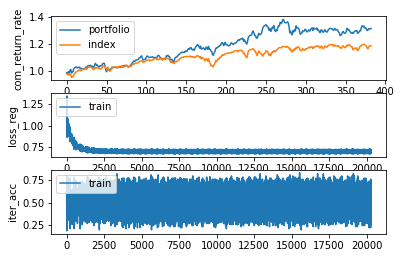

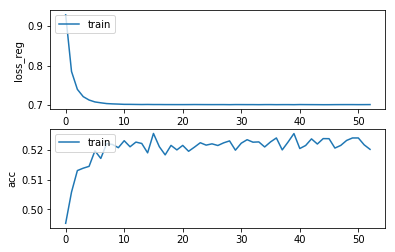

Epochs :  52 Iterations :  20299 Loss :  0.7011314172968852 ACC :  0.5201044548351522 MCC :  0.038319787946584395 Precision :  0.5227914816473779
mode : validation


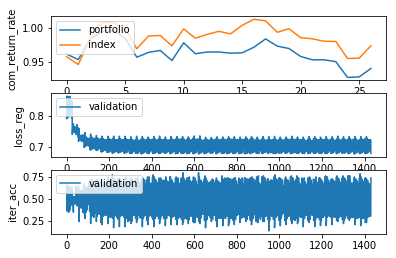

Epochs :  52 Iterations :  27 Loss :  0.7035689817534553 ACC :  0.4967320406878436 MCC :  nan Precision :  0.4913402627463694


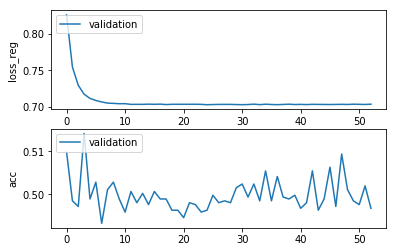

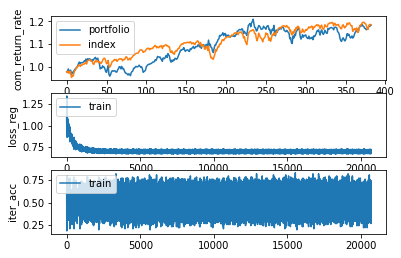

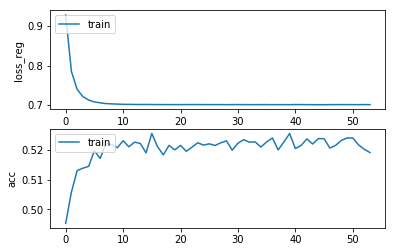

Epochs :  53 Iterations :  20682 Loss :  0.7009728401510273 ACC :  0.5190293509172709 MCC :  0.03614745739155617 Precision :  0.5217275860434879
mode : validation


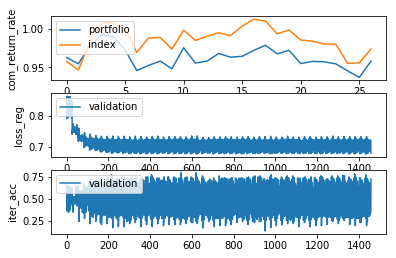

Epochs :  53 Iterations :  27 Loss :  0.7032998888580887 ACC :  0.5041394487575248 MCC :  nan Precision :  0.49517744731295993


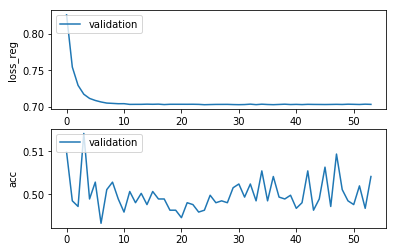

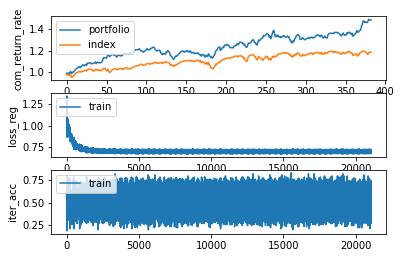

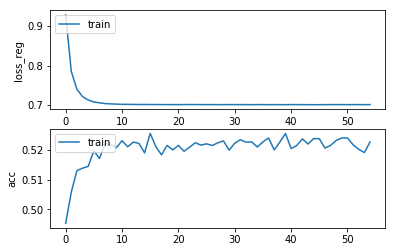

Epochs :  54 Iterations :  21065 Loss :  0.7011438874289511 ACC :  0.5225618345463556 MCC :  0.04474753564708154 Precision :  0.5242070113758583
mode : validation


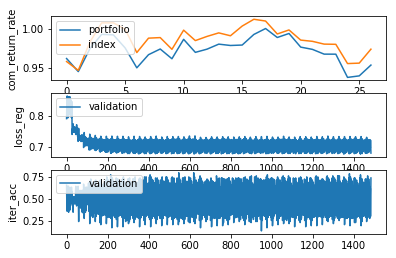

Epochs :  54 Iterations :  27 Loss :  0.7031155250690602 ACC :  0.5032679885625839 MCC :  nan Precision :  0.49193609726649745


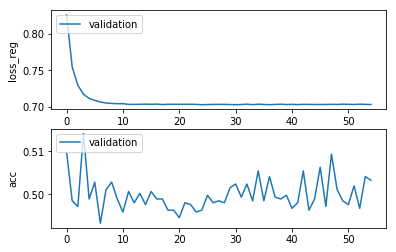

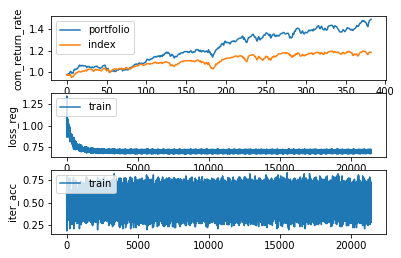

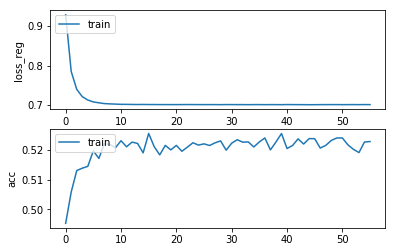

Epochs :  55 Iterations :  21448 Loss :  0.7010395477085761 ACC :  0.522715421126032 MCC :  0.04450969765353072 Precision :  0.5243715348242546
mode : validation


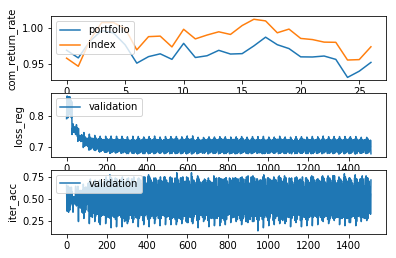

Epochs :  55 Iterations :  27 Loss :  0.70332713259591 ACC :  0.5041394487575248 MCC :  nan Precision :  0.4916185166824747


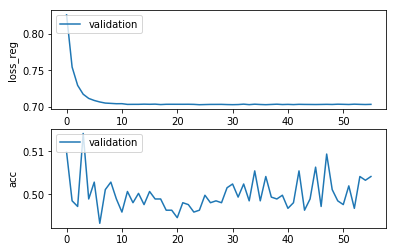

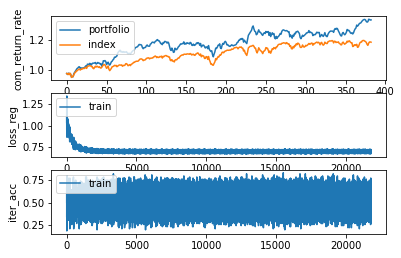

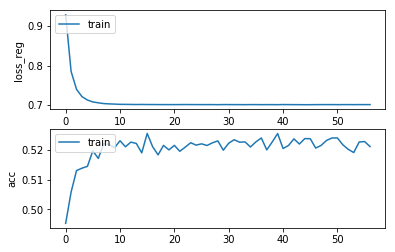

Epochs :  56 Iterations :  21831 Loss :  0.7010882856329178 ACC :  0.5210259717842929 MCC :  0.04128263312359717 Precision :  0.5233844608049013
mode : validation


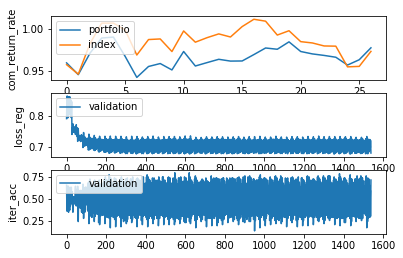

Epochs :  56 Iterations :  27 Loss :  0.7034784996951068 ACC :  0.5006536090815509 MCC :  nan Precision :  0.4925075394825803


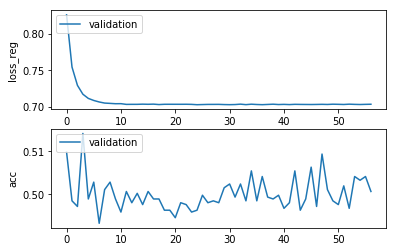

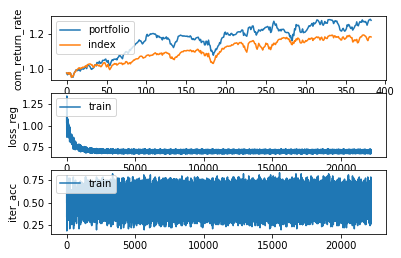

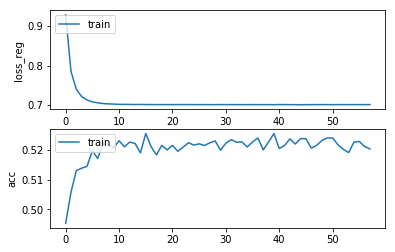

Epochs :  57 Iterations :  22214 Loss :  0.7010707095771173 ACC :  0.5202580405199808 MCC :  0.03381512245235055 Precision :  0.5215572264171923
mode : validation


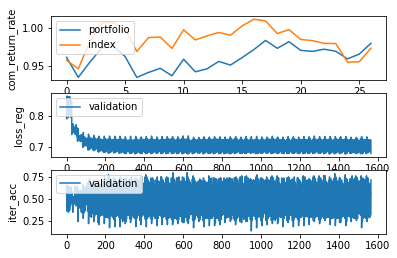

Epochs :  57 Iterations :  27 Loss :  0.7031892118630586 ACC :  0.49673204123973846 MCC :  nan Precision :  0.49146655781401527


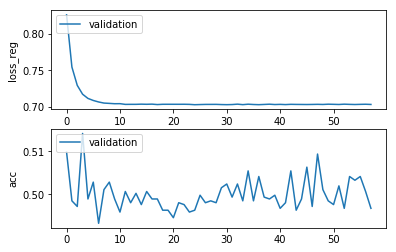

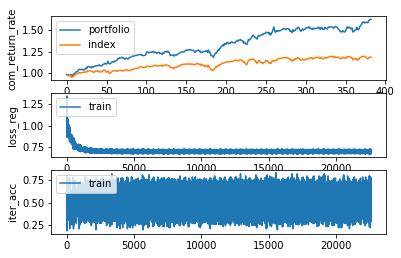

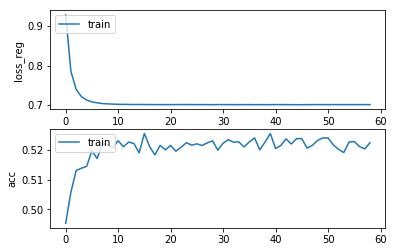

Epochs :  58 Iterations :  22597 Loss :  0.7010537462197147 ACC :  0.5223160966958452 MCC :  0.0439494614381168 Precision :  0.5240876018543856
mode : validation


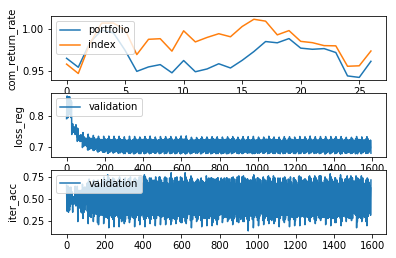

Epochs :  58 Iterations :  27 Loss :  0.7031579039714955 ACC :  0.4989106897954588 MCC :  nan Precision :  0.49217796891375826


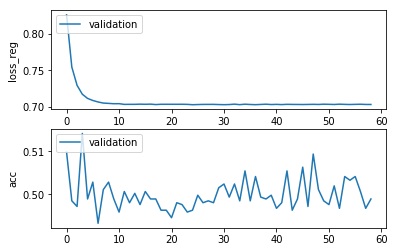

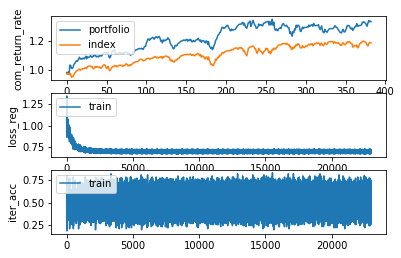

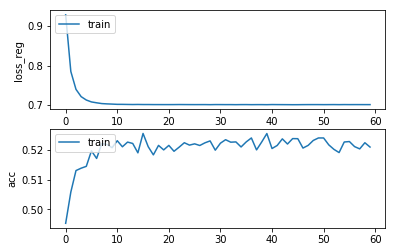

Epochs :  59 Iterations :  22980 Loss :  0.7010334756604685 ACC :  0.5208723858271193 MCC :  0.03793863663401251 Precision :  0.5223304492180715
mode : validation


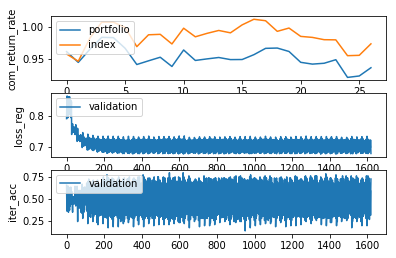

Epochs :  59 Iterations :  27 Loss :  0.703582935863071 ACC :  0.502396528367643 MCC :  nan Precision :  0.49178856086951717


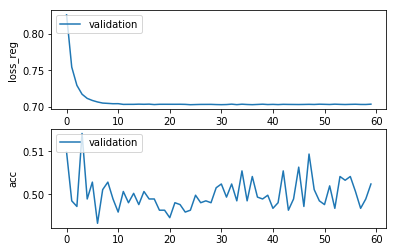

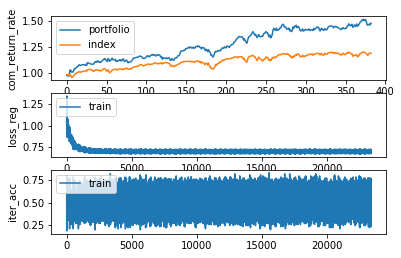

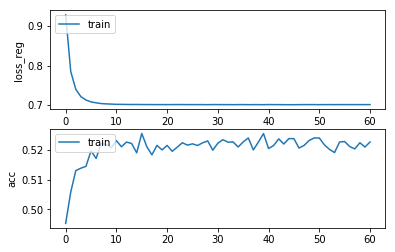

Epochs :  60 Iterations :  23363 Loss :  0.7010967924451703 ACC :  0.5225618341961977 MCC :  0.045190334720075054 Precision :  0.5242077469699299
mode : validation


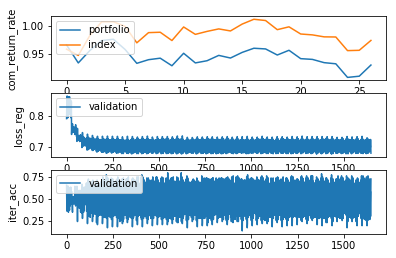

Epochs :  60 Iterations :  27 Loss :  0.7029132401501691 ACC :  0.5028322587410609 MCC :  nan Precision :  0.4942903801522873


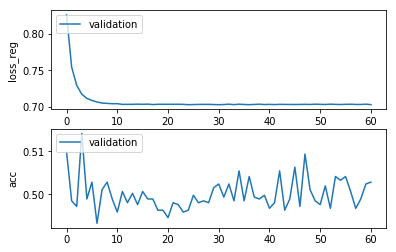

KeyboardInterrupt: 

In [51]:
model.train()

epoch :  0 time_idx :  0 loss_reg :  tensor(0.6864, grad_fn=<AddBackward0>) acc :  tensor(0.7059) mcc :  tensor(0.0585) precision :  tensor(0.9048)


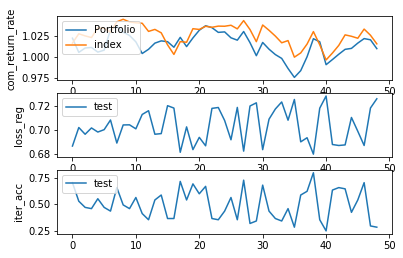

Epochs :  0 Iterations :  49 Loss :  0.703286633199575 ACC :  0.49939977362447857 MCC :  0.01962992332267518 Precision :  0.4792711289257419


In [52]:
model.test()

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.train() # dropout 없음, epochs = 5

In [ ]:
model.train() # dropout 0.15 적용

In [ ]:
model.test()

In [ ]:
model.test()

In [ ]:
model.train()

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.epoch_losses

In [ ]:
model.train()

In [ ]:
model.test()

In [ ]:
model.return_rate.shape

In [ ]:
ㄴmodel.train()

In [ ]:
model.train()